# Project Code Structure Analysis - 2D Fluid Prediction (FNO and UNet)

## Project Overview

This project uses the **CFDBench** dataset to train neural networks for predicting 2D fluid dynamics evolution. The core task is to learn the discrete Navier-Stokes update:

$$u^{t+\Delta t}(x) = G_\theta(u^t(x), BC, \nu, \rho, geometry)$$

where:
- $u$: velocity field (u, v components)
- $BC$: boundary conditions
- $\nu$: viscosity
- $\rho$: density
- $geometry$: geometry type (cylinder, cavity, dam, tube)

---

## Directory Structure

```
physics188Capstone/
├── data/                          # Dataset directory
│   └── CFDBench/                  # CFDBench dataset
│       ├── cylinder/              # Cylinder flow
│       ├── cavity/                # Lid-driven cavity flow
│       ├── dam/                   # Dam break
│       └── tube/                  # Tube flow
│
├── src/                           # source code
│   ├── models/                    # Model definitions
│   │   ├── FNO.py                 # Fourier Neural Operator (FNO)
│   │   └── UNet_lagecy.py         # UNet model
│   │
│   ├── data_handle/               # Data handling
│   │   ├── data.py                # simple data loader
│   │   └── testdata.py            # advanced dataset class (CFDBenchDataset)
│   │
│   ├── training/                  # training related
│   │   ├── trainer_general.py     # General trainer
│   │   ├── FNO.ipynb              # FNO training notebook
│   │   ├── UNet.ipynb             # UNet training notebook
│   │   ├── data.py                # data loading functions
│   │   ├── UNet_DOCUMENTATION.md  # UNet detailed documentation
│   │   └── epochs/                # Saved model checkpoints
│   │       ├── FNO_large/         # FNO large model weights
│   │       └── ...
│   │
│   ├── Visualize/                 # visualization
│   │   └── Visualize.ipynb        # visualization notebook (this file)
│   │
│   └── train.ipynb                # main training entry
│
└── ToDos/                         # TODOs
    └── VisualizationToDo.md
```

## Model Architecture

### 1. FNO (Fourier Neural Operator) - `src/models/FNO.py`

**Core Idea**: Perform convolution operations in the frequency domain to learn global features

```
Input [B, H, W, 10] → Lifting → FNO Blocks × N → Projection → Output [B, H, W, 2]
                    (Linear)   (Spectral Conv)    (Linear)
```

**Input Channels (10-dimensional)**:
- `u, v`: velocity components (2)
- `sdf`: signed distance function (1)
- `log_rho, log_mu`: log density and viscosity (2)
- `vel_bc`: boundary velocity (1)
- `geom_onehot`: geometry type encoding (4)

**Output Channels (2-dimensional)**: `u, v` predicted velocity

**Key Components**:
| Component | Description |
|-----------|-------------|
| `SpectralConv2d` | FFT → Frequency domain multiplication → IFFT |
| `FNOBlock` | Spectral convolution + Pointwise convolution + Residual connection |
| `Lifting` | Project input to high-dimensional space |
| `Projection` | Project from high dimension back to output space |

**Hyperparameters**:
- `width=32`: Hidden layer width
- `modes1=12, modes2=12`: Number of retained Fourier modes
- `n_layers=4`: Number of FNO blocks
- `padding=8`: Boundary padding

---

### 2. UNet - `src/models/UNet_lagecy.py`

**Core Idea**: Encoder-decoder architecture + skip connections

```
Input → [Encoder] → [Bottleneck] → [Decoder] → Output
          ↓_________skip connections_________↑
```

**Architecture**:
- **Encoder**: DoubleConv → MaxPool (4 layers: 64→128→256→512)
- **Bottleneck**: 512 → 1024
- **Decoder**: ConvTranspose2d → DoubleConv (4 layers: 1024→64)

**Advantage**: Faster on Mac systems (no FFT operations needed)

## Data Processing

### Dataset Class - `src/data_handle/testdata.py`

**`CFDBenchDataset`** - Main dataset class

**Supported Geometry Types**:
| Geometry Type | Description | SDF Calculation |
|----------|------|----------|
| `cylinder` | Cylinder flow | Distance to cylinder surface |
| `cavity` | Lid-driven cavity | Distance to nearest wall |
| `dam` | Dam break | Obstacle region marking |
| `tube` | Tube flow | Distance to upper/lower wall |

**Data Format**:
- Each case contains: `u.npy`, `v.npy`, `case.json`
- Velocity field shape: `[T, 64, 64]` (T = number of timesteps)
- Spatial resolution: 64×64 grid

**Input Feature Construction** (`__getitem__`):
```python
x = [u, v, sdf, log(rho), log(mu), vel_bc, geom_onehot×4]  # shape: [64, 64, 10]
y = [u_next, v_next]  # shape: [rollout_steps, 64, 64, 2]
```

**Key Functions**:
- `preload_all()`: Preload all data into RAM
- `stratified_split()`: Stratified split by case (prevent temporal leakage)
- `denormalize()`: Denormalize predictions

---

### Simple Data Loader - `src/data_handle/data.py`

**`Data`** - Simplified dataset class

Extracted metadata parameters:
- `vel_in`: Inlet velocity
- `density`, `viscosity`: Physical properties
- `radius`, `x_min`, `x_max`, `y_min`, `y_max`: Geometry parameters

## Training System

### General Trainer - `src/training/trainer_general.py`

**`Trainer` Class** - Complete training pipeline management

**Initialization Parameters**:
```python
Trainer(
    model,              # FNO or UNet model
    dataset,            # CFDBenchDataset
    epochs=50,          # Number of training epochs
    batch_size=16,      # Batch size
    lr=1e-4,            # Learning rate
    val_split=0.1,      # Validation set ratio
    device='cuda/mps/cpu'  # Computing device
)
```

**Training Modes**:

| Method | Description |
|--------|-------------|
| `train_single_step()` | Single-step prediction training (predict next timestep) |
| `train_autoregressive()` | Autoregressive training (multi-step rollout prediction) |

**Loss Functions**:
1. **Energy-Weighted MSE** (`_energy_weighted_loss`):
   $$L = MSE(pred, target) + \lambda \cdot MSE(KE_{pred}, KE_{target})$$
   where $KE = \frac{1}{2}(u^2 + v^2)$

2. **Compressibility Penalty** (`compressible_loss`):
   $$L_{div} = \omega \cdot \mathbb{E}[(\nabla \cdot \mathbf{u})^2]$$
   Enforce incompressible flow: $\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \approx 0$

**Evaluation Metrics** (`evaluate()`):
- MSE / RMSE: Mean squared error
- MAE: Mean absolute error
- Energy MAE: Kinetic energy error

---

### Training Notebooks

**FNO.ipynb** - FNO Model Training
- Data loading (BC subset)
- Geometry mask creation
- Single-step/autoregressive training
- Visualization of prediction results

**UNet.ipynb** - UNet Model Training
- Similar to FNO workflow
- Includes detailed performance evaluation

## Saved Model Weights

**Location**: `src/training/epochs/`

```
epochs/
├── FNO_large/                    # FNO large model
│   ├── best_model.pt             # Best single-step trained model
│   ├── best_model_ar.pt          # Best autoregressive trained model
│   └── training_log.txt          # Training log
│
├── FNO_1/                        # FNO experiment 1
│   ├── FNO_no_rollout/
│   │   └── model_weights_6       # Epoch 6 weights
│   └── rollout/
│       └── model_weights_0       # Rollout training weights
│
├── FNO_no_rollout/               # No rollout training
│   └── model_weights_6
│
└── rollout/                      # Rollout training
    └── model_weights_0
```

---

## Data Flow Summary

```
┌─────────────────────────────────────────────────────────────────┐
│                        Training Pipeline                        │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  CFDBench Data                                                  │
│  (u.npy, v.npy, case.json)                                     │
│         ↓                                                       │
│  CFDBenchDataset                                                │
│  - Compute SDF (signed distance function)                       │
│  - Extract physical parameters                                  │
│  - Construct input features [64, 64, 10]                        │
│         ↓                                                       │
│  DataLoader (batch_size=16)                                     │
│         ↓                                                       │
│  ┌──────────────┐     ┌──────────────┐                         │
│  │     FNO      │     │    UNet      │                         │
│  │(Freq-domain) │ OR  │(Encoder-Decoder)                       │
│  └──────────────┘     └──────────────┘                         │
│         ↓                                                       │
│  Predict next timestep [64, 64, 2]                             │
│         ↓                                                       │
│  Loss computation: MSE + Energy + Divergence                   │
│         ↓                                                       │
│  Backpropagation + Optimizer update                            │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

## Pending Visualization Tasks

Based on `ToDos/VisualizationToDo.md`:

- [ ] **Geometry Visualization**
  - [ ] FNO: Cylinder
  - [ ] FNO-large: All geometry types
  - [ ] UNet: Cylinder with different boundary conditions

- [ ] **Velocity Flow Field Visualization**: All geometry types
  - [ ] Evolution over time (timesteps)

- [ ] **Error Analysis**: FNO / FNO-large / UNet

- [ ] **Model Architecture Diagram**

- [ ] **Results Benchmark Comparison**

---

## 🔧 Usage Examples

### Load Model Example:

```python
import sys
sys.path.append('../')

from models.FNO import FNO
import torch

# Create model
model = FNO(
    in_channels=10,
    out_channels=2,
    width=32,
    modes1=12,
    modes2=12,
    n_layers=4
)

# Load weights
model.load_state_dict(torch.load('../training/epochs/FNO_large/best_model.pt'))
model.eval()
```

### Load Data Example:

```python
from data_handle.testdata import CFDBenchDataset, stratified_split

dataset = CFDBenchDataset(
    data_root='../../data/CFDBench',
    geometries='all',  # or ['cylinder', 'cavity']
    rollout_steps=1,
    normalize=True
)

train_set, val_set = stratified_split(dataset, val_fraction=0.15)
```

## Key File Quick Reference

| File | Purpose | Key Classes/Functions |
|------|---------|----------------------|
| `models/FNO.py` | FNO model definition | `FNO`, `SpectralConv2d`, `FNOBlock` |
| `models/UNet_lagecy.py` | UNet model definition | `UNet`, `DoubleConv` |
| `data_handle/testdata.py` | Advanced dataset | `CFDBenchDataset`, `stratified_split` |
| `data_handle/data.py` | Simple dataset | `Data` |
| `training/trainer_general.py` | Trainer | `Trainer` |
| `training/FNO.ipynb` | FNO training workflow | - |
| `training/UNet.ipynb` | UNet training workflow | - |

---

## Next Steps

The following cells will start with actual visualization code...

## Detailed Geometry Information Used by FNO Model

### Training Data Source

Based on analysis of `FNO.ipynb`, the FNO models primarily use the following data:

| Model Version | Geometry Type | Data Subset | Training Config |
|----------|----------|----------|----------|
| **FNO (FNO.ipynb)** | Cylinder | `bc` (boundary condition) | width=64, modes=16, layers=4 |
| **FNO_1** | Cylinder | `bc` | width=32, modes=16, layers=3 |
| **FNO_large** | **All geometries** (cylinder, cavity, dam, tube) | Full | Uses `CFDBenchDataset` |

---

### Cylinder (Cylinder Flow) - Main Geometry

This is the **only geometry type** used in `FNO.ipynb`, with data from the `bc` (boundary condition) subset.

**case.json Parameter Structure**:
```json
{
    "vel_in": 1.0,       // Inlet velocity (m/s)
    "density": 1.0,      // Fluid density (kg/m³)
    "viscosity": 0.01,   // Dynamic viscosity (Pa·s)
    "radius": 0.5,       // Cylinder radius (centered at origin)
    "x_min": -4.0,       // Computational domain X minimum boundary
    "x_max": 12.0,       // Computational domain X maximum boundary
    "y_min": -4.0,       // Computational domain Y minimum boundary
    "y_max": 4.0         // Computational domain Y maximum boundary
}
```

**Geometry Diagram**:
```
        y_max ────────────────────────────
              │                          │
              │    ●────→ Flow direction  │
              │   ╱╲                     │
        0 ────│──●  ● (Cylinder, r=radius)
              │   ╲╱                     │
              │                          │
        y_min ────────────────────────────
              x_min        0           x_max
                     inlet
```

---

### All Geometry Types Supported by FNO_large

FNO_large uses `CFDBenchDataset` (defined in `testdata.py`), supporting 4 geometries:

#### 1. Cylinder (Cylinder Flow)
```python
Parameters: {x_min, x_max, y_min, y_max, radius, vel_in, density, viscosity}
SDF:  sqrt(x² + y²) - radius  (cylinder center at origin)
```

#### 2. Cavity (Lid-Driven Cavity Flow)
```python
Parameters: {vel_top, density, viscosity, rotated}
SDF:  min(x, 1-x, y, 1-y)  (distance to nearest wall)
Feature: Top wall driven at vel_top velocity to induce flow
```

#### 3. Dam (Dam Break)
```python
Parameters: {barrier_height, barrier_width, height, width, velocity, density, viscosity}
SDF:  obstacle region marking (-0.1 interior, 0.5 exterior)
Feature: Free-surface flow with bottom obstacle
```

#### 4. Tube (Tube Flow)
```python
Parameters: {vel_in, density, viscosity}
SDF:  min(y, 1-y)  (distance to upper/lower wall)
Feature: Simple laminar/turbulent tube flow
```

---

### Parameter Difference Summary

| Parameter | Cylinder | Cavity | Dam | Tube |
|------|:--------:|:------:|:---:|:----:|
| `x_min, x_max` | ✅ | ❌ | ❌ | ❌ |
| `y_min, y_max` | ✅ | ❌ | ❌ | ❌ |
| `radius` | ✅ | ❌ | ❌ | ❌ |
| `vel_in` | ✅ | ❌ | ❌ | ✅ |
| `vel_top` | ❌ | ✅ | ❌ | ❌ |
| `velocity` | ❌ | ❌ | ✅ | ❌ |
| `barrier_height/width` | ❌ | ❌ | ✅ | ❌ |
| `height, width` | ❌ | ❌ | ✅ | ❌ |
| `rotated` | ❌ | ⚪ | ❌ | ❌ |
| `density` | ✅ | ✅ | ✅ | ✅ |
| `viscosity` | ✅ | ✅ | ✅ | ✅ |

---

### Training History (FNO_large)

Based on `training_log.txt`:

| Stage | Training Type | Epochs | Final Train Loss | Final Val Loss |
|------|----------|--------|-----------------|---------------|
| Part 1 | Single-step | 11 | 0.0077 | 0.0133 |
| Part 2 | Single-step | 22 | 0.0097 | 0.0233 |
| Part 3 | Single-step | 19 | 0.00075 | 0.00077 |
| Part 4 | **Autoregressive (rollout=5)** | 30 | 0.00186 | 0.00157 |

**Best Model**: `best_model_ar.pt` (autoregressive training, Val Loss = 0.00157)

## Cavity (Lid-Driven Cavity Flow) Detailed Analysis

### Physical Problem Description

Lid-driven cavity flow is one of the classic benchmark problems in CFD.




---

### case.json 

```json
{
    "vel_top": 1.0,       // 顶部壁面速度 (m/s)，范围: 1-50 m/s
    "density": 1.0,       // 流体密度 (kg/m³)，范围: 10-1000
    "viscosity": 0.01,    // 动力粘度 (Pa·s)，范围: 0.01-1.0
    "height": 1.0,        // 空腔高度 (m)
    "width": 1.0,         // 空腔宽度 (m)
    "rotated": false      // 可选：是否旋转几何
}
```



---

### SDF (Signed Distance Function) Calculation

```python
def _sdf_cavity(meta: dict, H: int, W: int) -> np.ndarray:
    """计算到最近墙壁的距离"""
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    X, Y = np.meshgrid(x, y, indexing='xy')
    
    # Minimum distance to four walls
    sdf = np.minimum(
        np.minimum(X, 1 - X),      # left/right walls
        np.minimum(Y, 1 - Y)       # top/bottom walls
    )
    
    if meta.get('rotated', False):
        sdf = np.rot90(sdf)
    
    return sdf.astype(np.float32)
```


In [19]:
# ========================================
# UNet Model Definition
# ========================================

import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Optional

# Device detection
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: Apple Metal Performance Shaders (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
else:
    device = torch.device("cpu")
    print("Using device: CPU")


class DoubleConv(nn.Module):
    """Double convolution block with replicate padding and bias"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                mid_channels,
                kernel_size=3,
                padding=1,
                bias=True,
                padding_mode="replicate",
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=True,
                padding_mode="replicate",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        in_channels: int = 11,
        out_channels: int = 2,
        features: List[int] = [64, 128, 256, 512],
        n_case_params: int = 9,
        insert_case_params_at: str = "hidden",
        bilinear: bool = False,
        use_residual: bool = True,
        use_output_mask: bool = True,
    ):
        super().__init__()
        assert insert_case_params_at in ["input", "hidden"]

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_case_params = n_case_params
        self.insert_case_params_at = insert_case_params_at
        self.bilinear = bilinear
        self.use_residual = use_residual
        self.use_output_mask = use_output_mask

        if insert_case_params_at == "hidden":
            self.case_params_fc = nn.Linear(n_case_params, features[-1] * 2)

        if insert_case_params_at == "input":
            self.in_conv = DoubleConv(in_channels + 1 + n_case_params, features[0])
        else:
            self.in_conv = DoubleConv(in_channels + 1, features[0])  # +1 for mask

        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        factor = 2 if bilinear else 1
        self.down4 = Down(features[3], features[3] * 2 // factor)

        self.up1 = Up(features[3] * 2, features[3] // factor, bilinear)
        self.up2 = Up(features[3], features[2] // factor, bilinear)
        self.up3 = Up(features[2], features[1] // factor, bilinear)
        self.up4 = Up(features[1], features[0], bilinear)

        self.out_conv = OutConv(features[0], out_channels)

    def forward(
        self,
        x: torch.Tensor,
        case_params: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        # Accept channels-last or channels-first
        if len(x.shape) == 4 and (x.shape[-1] == 11 or x.shape[-1] == 2):
            x = x.permute(0, 3, 1, 2)  # [B,H,W,C] -> [B,C,H,W]

        batch_size, _, height, width = x.shape

        residual = x[:, : self.out_channels] if self.use_residual else None

        # Mask
        if mask is None:
            mask = torch.ones((batch_size, height, width), device=x.device, dtype=x.dtype)
        else:
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)  # [B,1,H,W]
            elif mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)

        mask_input = mask if mask.dim() == 4 else mask.unsqueeze(1)
        x = torch.cat([x, mask_input], dim=1)  # [B, C+1, H, W]

        # Optional params at input
        if self.insert_case_params_at == "input" and case_params is not None:
            case_params = case_params.unsqueeze(2).unsqueeze(3)  # [B,n,1,1]
            case_params = case_params.expand(-1, -1, height, width)
            x = torch.cat([x, case_params], dim=1)

        # Encoder
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Hidden conditioning
        if self.insert_case_params_at == "hidden" and case_params is not None:
            conds = self.case_params_fc(case_params).unsqueeze(2).unsqueeze(3)
            x5 = x5 + conds

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        preds = self.out_conv(x)  # [B,2,H,W]

        if self.use_residual and residual is not None:
            preds = preds + residual

        if self.use_output_mask:
            mask_out = mask.squeeze(1) if mask.dim() == 4 else mask
            if mask_out.dim() == 2:
                mask_out = mask_out.unsqueeze(0)
            preds = preds * mask_out.unsqueeze(1)

        preds = preds.permute(0, 2, 3, 1)  # [B,H,W,2]
        return preds

print("✅ UNet model definition completed")

Using device: Apple Metal Performance Shaders (MPS)
✅ UNet 模型定义完成


In [20]:
# ========================================
# Method 1: Print model summary using torchsummary
# ========================================
# Installation: pip install torchsummary

try:
    from torchsummary import summary
    
    # 创建模型实例
    model = UNet(
        in_channels=11,
        out_channels=2,
        features=[64, 128, 256, 512],
        n_case_params=9,
        insert_case_params_at="hidden",
        bilinear=False,
        use_residual=True,
        use_output_mask=True,
    )
    model = model.to(device)
    
    print("=" * 70)
    print("📊 UNet 模型结构摘要 (torchsummary)")
    print("=" * 70)
    print(f"\n输入: [B, 11, 64, 64] + mask [B, 1, 64, 64] = [B, 12, 64, 64]")
    print(f"输出: [B, 64, 64, 2]")
    print("-" * 70)
    
    # 注意: summary 需要输入尺寸 (channels, height, width)
    # UNet 输入: in_channels=11 + mask=1 = 12 channels, 64x64 分辨率
    summary(model, input_size=(11, 64, 64), device=str(device))
    
except ImportError:
    print("⚠️ torchsummary 未安装，请运行: pip install torchsummary")
    print("\n使用 print(model) 替代:")
    print("=" * 70)
    model = UNet(
        in_channels=11,
        out_channels=2,
        features=[64, 128, 256, 512],
        n_case_params=9,
        insert_case_params_at="hidden",
        bilinear=False,
    )
    print(model)
except Exception as e:
    print(f"⚠️ torchsummary 错误: {e}")
    print("\n使用 print(model) 替代:")
    model = UNet(
        in_channels=11,
        out_channels=2,
        features=[64, 128, 256, 512],
        n_case_params=9,
    )
    print(model)

📊 UNet 模型结构摘要 (torchsummary)

输入: [B, 11, 64, 64] + mask [B, 1, 64, 64] = [B, 12, 64, 64]
输出: [B, 64, 64, 2]
----------------------------------------------------------------------
⚠️ torchsummary 错误: Input device is not valid, please specify 'cuda' or 'cpu'

使用 print(model) 替代:
UNet(
  (case_params_fc): Linear(in_features=9, out_features=1024, bias=True)
  (in_conv): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, di

📈 生成 UNet 计算图 (torchviz)
✅ 计算图已保存为: unet_architecture.png


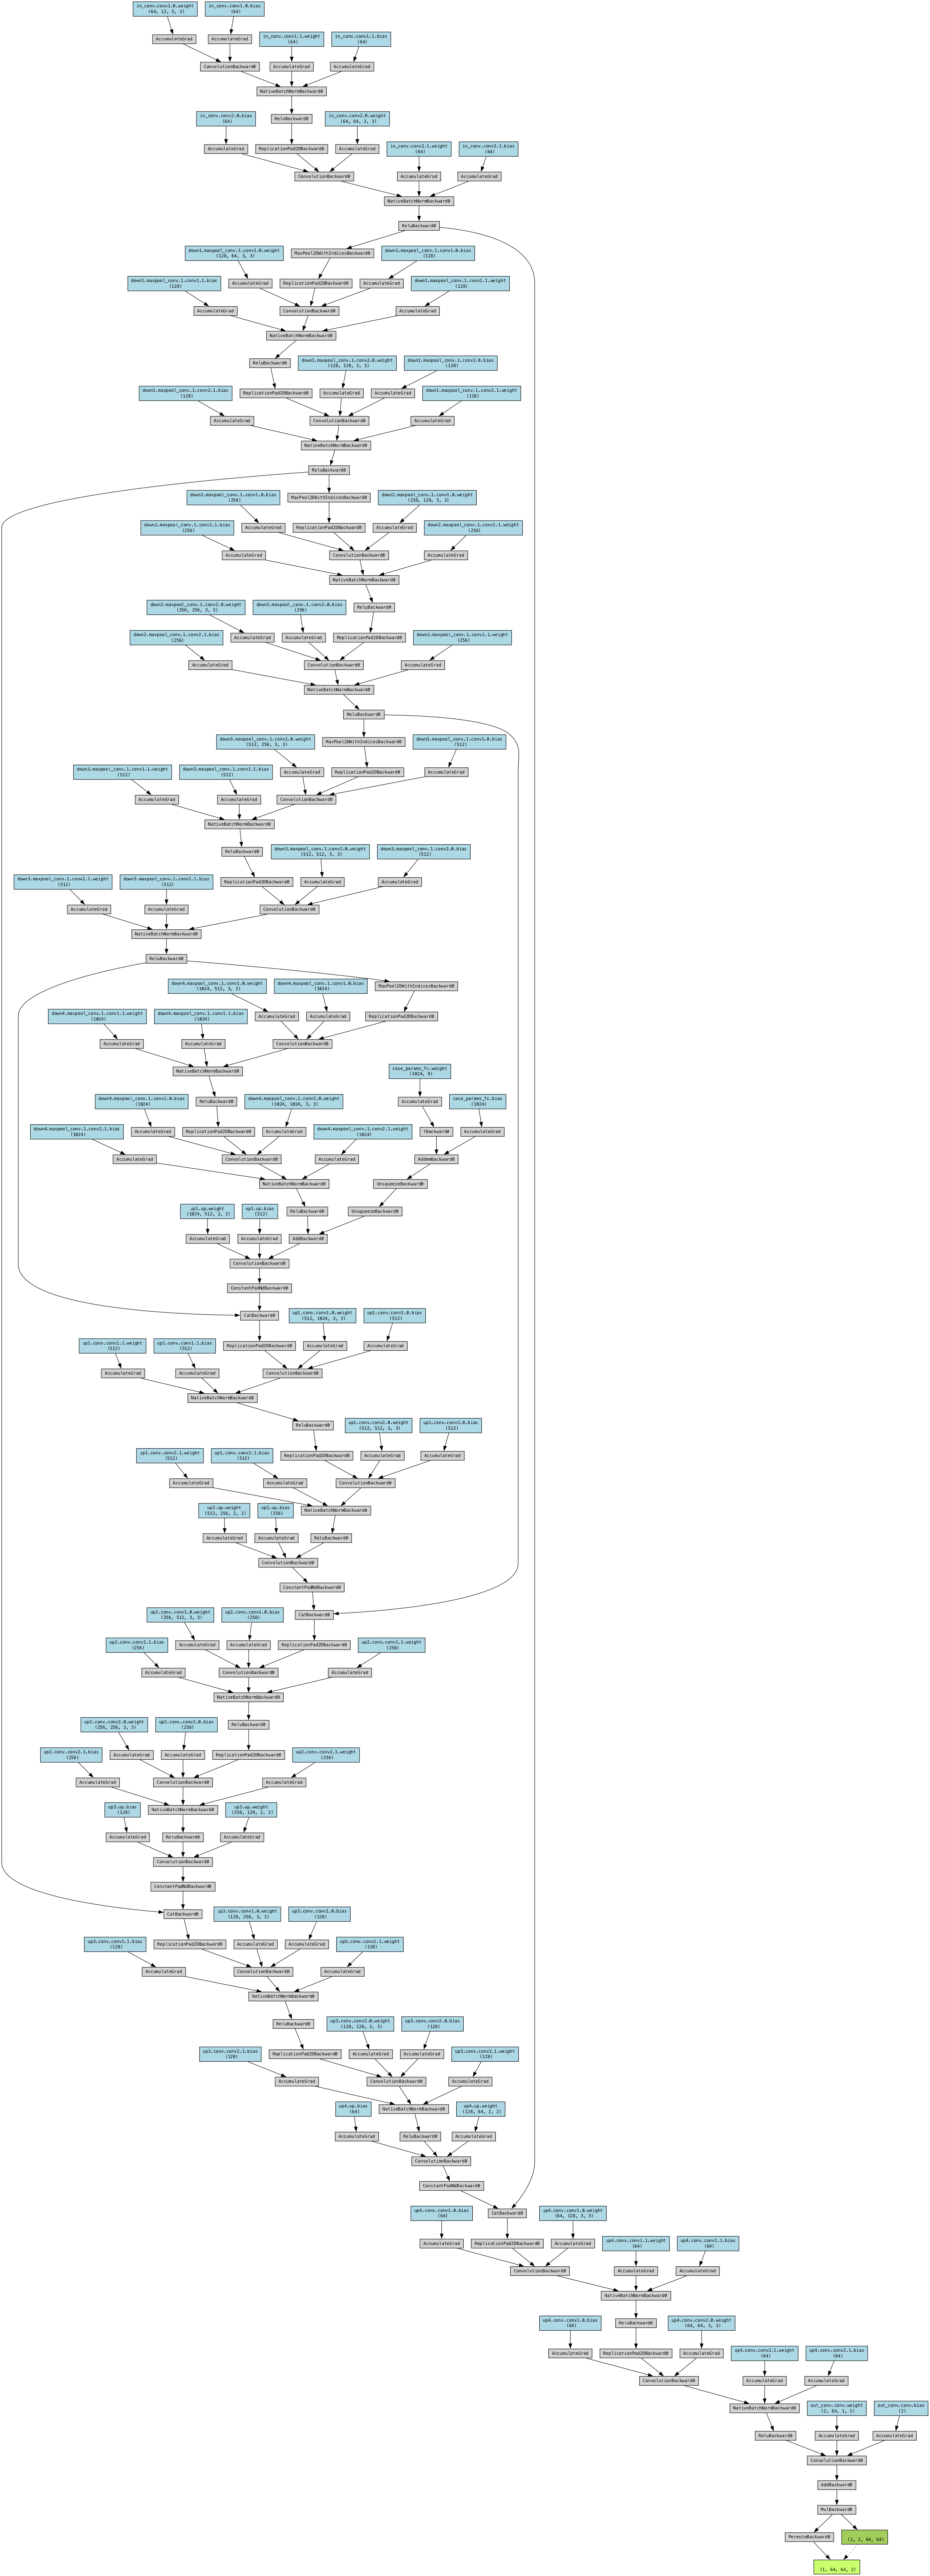

In [21]:
# Method 2: Generate computation graph using torchviz
# ========================================
# Installation: pip install torchviz
# Also need to install graphviz: brew install graphviz (macOS)

try:
    from torchviz import make_dot
    
    print("=" * 70)
    print("📈 生成 UNet 计算图 (torchviz)")
    print("=" * 70)
    
    # 为 torchviz 使用 CPU 设备（避免 MPS 兼容性问题）
    viz_device = torch.device("cpu")
    
    # 创建新的模型实例并放到 CPU 上
    viz_model = UNet(
        in_channels=11,
        out_channels=2,
        features=[64, 128, 256, 512],
        n_case_params=9,
        insert_case_params_at="hidden",
        bilinear=False,
        use_residual=True,
        use_output_mask=True,
    ).to(viz_device)
    
    # 创建虚拟输入 (都在 CPU 上)
    dummy_input = torch.randn(1, 11, 64, 64, device=viz_device)
    dummy_case_params = torch.randn(1, 9, device=viz_device)
    dummy_mask = torch.ones(1, 64, 64, device=viz_device)
    
    # 前向传播获取输出 (需要梯度)
    viz_model.train()
    output = viz_model(dummy_input, case_params=dummy_case_params, mask=dummy_mask)
    
    # 生成计算图
    dot = make_dot(
        output, 
        params=dict(viz_model.named_parameters()), 
        show_attrs=False, 
        show_saved=False
    )
    dot.format = 'png'
    
    # 保存图像
    output_path = dot.render('unet_architecture', cleanup=True)
    print(f"✅ 计算图已保存为: {output_path}")
    
    # 显示图像
    from IPython.display import Image, display
    display(Image(filename='unet_architecture.png'))
    
except ImportError as e:
    print(f"⚠️ 缺少依赖: {e}")
    print("请安装: pip install torchviz")
    print("macOS 还需要: brew install graphviz")
except Exception as e:
    print(f"⚠️ torchviz 渲染失败: {e}")
    print("请确保已安装 graphviz:")
    print("  - macOS: brew install graphviz")
    print("  - Ubuntu: sudo apt-get install graphviz")

UNet architecture diagram saved as: unet_architecture_diagram.png


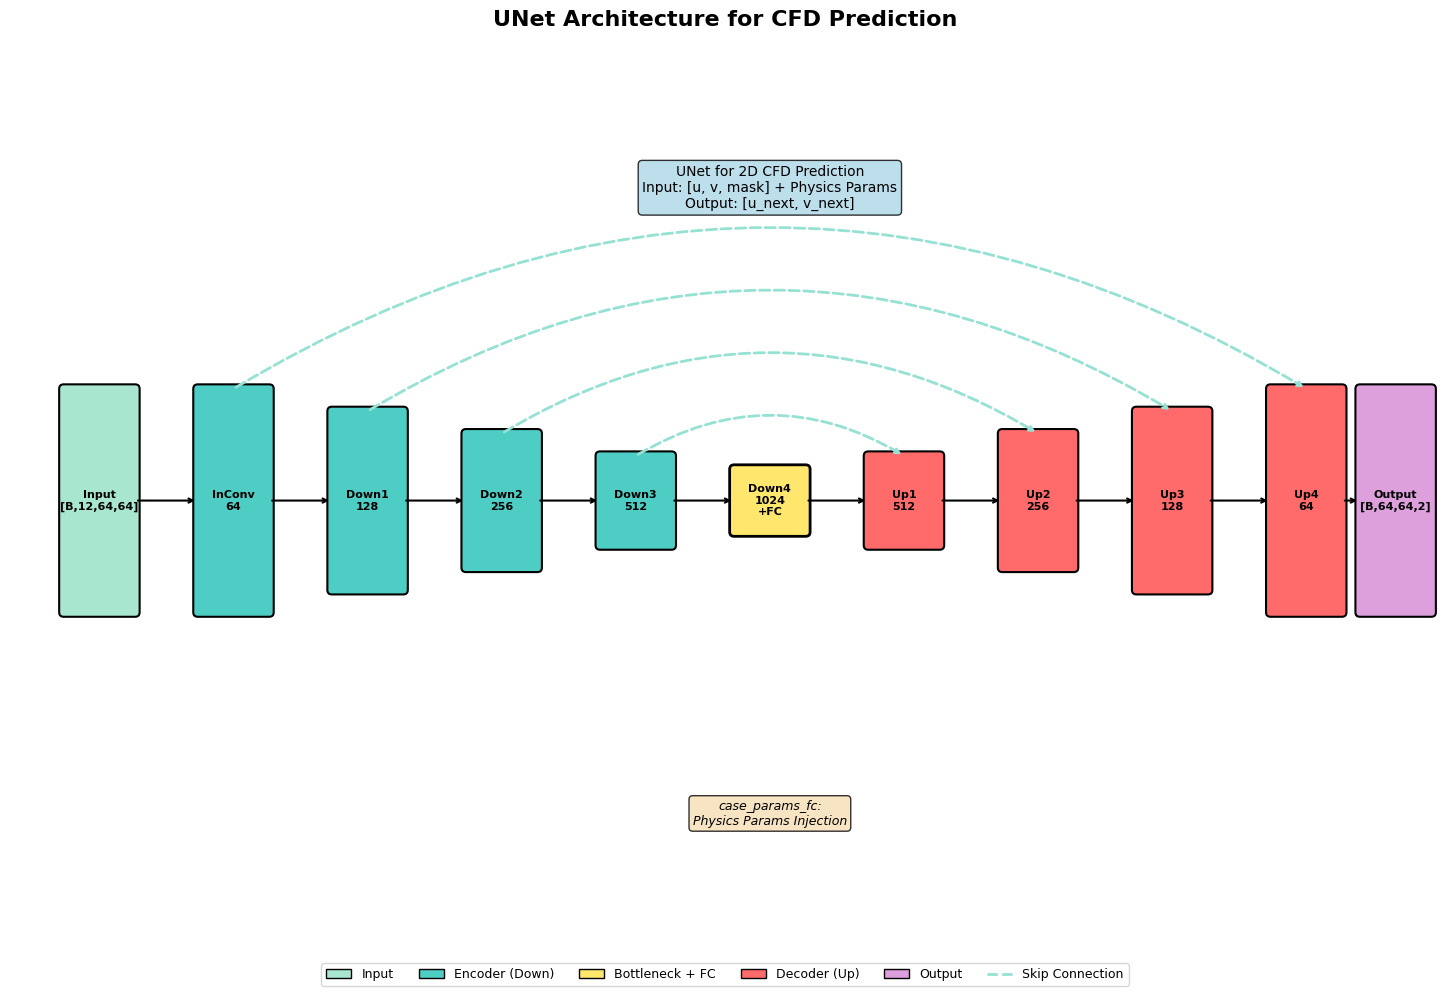

In [22]:
# ========================================
# Method 3: Draw UNet Architecture with matplotlib
# ========================================
# No extra installation needed, uses built-in libraries

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_unet_architecture():
    """Draw UNet architecture diagram"""
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('UNet Architecture for CFD Prediction', fontsize=16, fontweight='bold', pad=20)
    
    # Color definitions
    encoder_color = '#4ECDC4'  # Cyan - Encoder
    decoder_color = '#FF6B6B'  # Red - Decoder
    bottleneck_color = '#FFE66D'  # Yellow - Bottleneck
    skip_color = '#95E1D3'  # Light green - Skip connections
    input_color = '#A8E6CF'  # Light green - Input
    output_color = '#DDA0DD'  # Purple - Output
    
    # Layer info [name, channels, x_pos, y_pos, height]
    encoder_layers = [
        ('Input\n[B,12,64,64]', 12, 1, 5, 2.5),
        ('InConv\n64', 64, 2.5, 5, 2.5),
        ('Down1\n128', 128, 4, 5, 2.0),
        ('Down2\n256', 256, 5.5, 5, 1.5),
        ('Down3\n512', 512, 7, 5, 1.0),
    ]
    
    bottleneck = ('Down4\n1024\n+FC', 1024, 8.5, 5, 0.7)
    
    decoder_layers = [
        ('Up1\n512', 512, 10, 5, 1.0),
        ('Up2\n256', 256, 11.5, 5, 1.5),
        ('Up3\n128', 128, 13, 5, 2.0),
        ('Up4\n64', 64, 14.5, 5, 2.5),
    ]
    
    output_layer = ('Output\n[B,64,64,2]', 2, 15.5, 5, 2.5)
    
    # Draw encoder blocks
    for name, channels, x, y, h in encoder_layers:
        color = input_color if 'Input' in name else encoder_color
        rect = patches.FancyBboxPatch((x-0.4, y-h/2), 0.8, h, 
                                       boxstyle="round,pad=0.05", 
                                       facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(x, y, name, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Draw bottleneck layer
    name, channels, x, y, h = bottleneck
    rect = patches.FancyBboxPatch((x-0.4, y-h/2), 0.8, h, 
                                   boxstyle="round,pad=0.05", 
                                   facecolor=bottleneck_color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y, name, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Draw decoder blocks
    for name, channels, x, y, h in decoder_layers:
        rect = patches.FancyBboxPatch((x-0.4, y-h/2), 0.8, h, 
                                       boxstyle="round,pad=0.05", 
                                       facecolor=decoder_color, edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(x, y, name, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Draw output layer
    name, channels, x, y, h = output_layer
    rect = patches.FancyBboxPatch((x-0.4, y-h/2), 0.8, h, 
                                   boxstyle="round,pad=0.05", 
                                   facecolor=output_color, edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x, y, name, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Draw connection arrows (Encoder -> Bottleneck -> Decoder -> Output)
    arrow_style = patches.ArrowStyle('->', head_length=0.3, head_width=0.15)
    
    # Encoder connections
    for i in range(len(encoder_layers) - 1):
        x1 = encoder_layers[i][2] + 0.4
        x2 = encoder_layers[i+1][2] - 0.4
        ax.annotate('', xy=(x2, 5), xytext=(x1, 5),
                   arrowprops=dict(arrowstyle=arrow_style, color='black', lw=1.5))
    
    # Encoder -> Bottleneck
    ax.annotate('', xy=(bottleneck[2]-0.4, 5), xytext=(encoder_layers[-1][2]+0.4, 5),
               arrowprops=dict(arrowstyle=arrow_style, color='black', lw=1.5))
    
    # Bottleneck -> Decoder
    ax.annotate('', xy=(decoder_layers[0][2]-0.4, 5), xytext=(bottleneck[2]+0.4, 5),
               arrowprops=dict(arrowstyle=arrow_style, color='black', lw=1.5))
    
    # Decoder connections
    for i in range(len(decoder_layers) - 1):
        x1 = decoder_layers[i][2] + 0.4
        x2 = decoder_layers[i+1][2] - 0.4
        ax.annotate('', xy=(x2, 5), xytext=(x1, 5),
                   arrowprops=dict(arrowstyle=arrow_style, color='black', lw=1.5))
    
    # Decoder -> Output
    ax.annotate('', xy=(output_layer[2]-0.4, 5), xytext=(decoder_layers[-1][2]+0.4, 5),
               arrowprops=dict(arrowstyle=arrow_style, color='black', lw=1.5))
    
    # Draw skip connections
    skip_pairs = [
        (encoder_layers[1], decoder_layers[3]),  # 64 -> 64
        (encoder_layers[2], decoder_layers[2]),  # 128 -> 128
        (encoder_layers[3], decoder_layers[1]),  # 256 -> 256
        (encoder_layers[4], decoder_layers[0]),  # 512 -> 512
    ]
    
    for (enc, dec), offset in zip(skip_pairs, [3.5, 2.8, 2.2, 1.6]):
        x1, y1, h1 = enc[2], 5, enc[4]
        x2, y2, h2 = dec[2], 5, dec[4]
        
        # Draw curved skip connection
        mid_y = y1 + offset
        ax.annotate('', 
                   xy=(x2, y2 + h2/2), 
                   xytext=(x1, y1 + h1/2),
                   arrowprops=dict(
                       arrowstyle=arrow_style, 
                       color=skip_color, 
                       lw=2,
                       connectionstyle=f'arc3,rad=-0.3',
                       linestyle='--'
                   ))
    
    # Add legend
    legend_elements = [
        patches.Patch(facecolor=input_color, edgecolor='black', label='Input'),
        patches.Patch(facecolor=encoder_color, edgecolor='black', label='Encoder (Down)'),
        patches.Patch(facecolor=bottleneck_color, edgecolor='black', label='Bottleneck + FC'),
        patches.Patch(facecolor=decoder_color, edgecolor='black', label='Decoder (Up)'),
        patches.Patch(facecolor=output_color, edgecolor='black', label='Output'),
        plt.Line2D([0], [0], color=skip_color, linestyle='--', lw=2, label='Skip Connection'),
    ]
    ax.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=9, 
              bbox_to_anchor=(0.5, -0.05))
    
    # Add annotations
    ax.text(8.5, 1.5, 'case_params_fc:\nPhysics Params Injection', ha='center', va='center', 
            fontsize=9, style='italic', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.text(8.5, 8.5, 'UNet for 2D CFD Prediction\nInput: [u, v, mask] + Physics Params\nOutput: [u_next, v_next]', 
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('unet_architecture_diagram.png', dpi=150, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print("UNet architecture diagram saved as: unet_architecture_diagram.png")
    plt.show()

# Draw architecture diagram
draw_unet_architecture()

In [23]:
# ========================================
# Method 4: Print detailed layer parameter statistics
# ========================================

def count_parameters(model):
    """统计模型参数数量"""
    total_params = 0
    trainable_params = 0
    
    print("=" * 80)
    print("📊 UNet 模型参数统计")
    print("=" * 80)
    print(f"{'层名称':<40} {'参数形状':<25} {'参数数量':>12}")
    print("-" * 80)
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        
        shape_str = str(list(param.shape))
        print(f"{name:<40} {shape_str:<25} {param_count:>12,}")
    
    print("-" * 80)
    print(f"{'总参数量':<65} {total_params:>12,}")
    print(f"{'可训练参数量':<65} {trainable_params:>12,}")
    print(f"{'参数内存 (MB, float32)':<65} {total_params * 4 / 1024 / 1024:>12.2f}")
    print("=" * 80)
    
    return total_params, trainable_params

# 创建模型并统计参数
model = UNet(
    in_channels=11,
    out_channels=2,
    features=[64, 128, 256, 512],
    n_case_params=9,
    insert_case_params_at="hidden",
    bilinear=False,
)

total, trainable = count_parameters(model)

# 各模块参数分布
print("\n📈 各模块参数分布:")
print("-" * 50)

module_params = {
    'in_conv': 0,
    'down1': 0,
    'down2': 0,
    'down3': 0,
    'down4': 0,
    'case_params_fc': 0,
    'up1': 0,
    'up2': 0,
    'up3': 0,
    'up4': 0,
    'out_conv': 0,
}

for name, param in model.named_parameters():
    for module_name in module_params.keys():
        if name.startswith(module_name):
            module_params[module_name] += param.numel()
            break

for module_name, param_count in module_params.items():
    pct = param_count / total * 100
    bar = '█' * int(pct / 2) + '░' * (50 - int(pct / 2))
    print(f"{module_name:<20} {param_count:>10,} ({pct:>5.1f}%) {bar[:20]}")

📊 UNet 模型参数统计
层名称                                      参数形状                              参数数量
--------------------------------------------------------------------------------
case_params_fc.weight                    [1024, 9]                        9,216
case_params_fc.bias                      [1024]                           1,024
in_conv.conv1.0.weight                   [64, 12, 3, 3]                   6,912
in_conv.conv1.0.bias                     [64]                                64
in_conv.conv1.1.weight                   [64]                                64
in_conv.conv1.1.bias                     [64]                                64
in_conv.conv2.0.weight                   [64, 64, 3, 3]                  36,864
in_conv.conv2.0.bias                     [64]                                64
in_conv.conv2.1.weight                   [64]                                64
in_conv.conv2.1.bias                     [64]                                64
down1.maxpool_conv.1.conv

## FNO

### FNO Model Overview

The Fourier Neural Operator learns mappings between function spaces by operating in the frequency domain. It's particularly effective for PDEs like Navier-Stokes.

### Structure of FNO Model

```
Input [B, H, W, 10]
       │
       ▼ (Zero Padding: +8 on each side)
[B, H+16, W+16, 10]
       │
       ▼ (Lifting Layer: Linear 10 → width)
[B, H+16, W+16, width]
       │
       ▼ (Permute to channels-first)
[B, width, H+16, W+16]
       │
       ▼
┌─────────────────────────────────────────────────────────┐
│                   FNO Block × N                         │
├─────────────────────────────────────────────────────────┤
│                                                         │
│    Input x ──────────────────────────────┐             │
│       │                                  │ (Residual)   │
│       ├─────────────┬────────────────┐  │             │
│       ▼             ▼                │  │             │
│  ┌─────────┐   ┌─────────┐          │  │             │
│  │SpectralConv│   │Conv2d 1×1│         │  │             │
│  │   2D     │   │(Pointwise)│         │  │             │
│  └────┬────┘   └────┬────┘          │  │             │
│       │             │                │  │             │
│       └─────┬───────┘                │  │             │
│             ▼                        │  │             │
│         (+) Add                      │  │             │
│             │                        │  │             │
│             ▼                        │  │             │
│          GELU                        │  │             │
│             │                        │  │             │
│             ▼                        │  │             │
│      InstanceNorm2d                  │  │             │
│             │                        │  │             │
│             └────────────────────────┼──┘             │
│                                      ▼                 │
│                                   (+) Add              │
│                                      │                 │
│                                      ▼                 │
│                                   Output               │
└─────────────────────────────────────────────────────────┘
       │
       ▼ (Permute back)
[B, H+16, W+16, width]
       │
       ▼ (Projection: Linear width → 128 → GELU → 2)
[B, H+16, W+16, 2]
       │
       ▼ (Crop padding)
[B, H, W, 2] = Output
```

### SpectralConv2d Operation (Frequency Domain Convolution)

```
Input x [B, C, H, W]
       │
       ▼ FFT2D (Real)
x_ft [B, C, H, W//2+1] (complex)
       │
       ├─── Low frequency modes (0:modes1, 0:modes2)
       │         × weights1 (learned complex weights)
       │
       ├─── High frequency modes (-modes1:, 0:modes2)
       │         × weights2 (learned complex weights)
       │
       ▼ IFFT2D
Output [B, C, H, W] (real)
```

### 关键组件

| Component | Input → Output | Description |
|-----------|---------------|-------------|
| `fc0` (Lifting) | [B,H,W,10] → [B,H,W,32] | Project to hidden dim |
| `SpectralConv2d` | [B,32,H,W] → [B,32,H,W] | FFT-based global convolution |
| `Conv2d(1×1)` | [B,32,H,W] → [B,32,H,W] | Local/pointwise features |
| `FNOBlock` | [B,32,H,W] → [B,32,H,W] | Spectral + Local + Residual |
| `fc1` (Project) | [B,H,W,32] → [B,H,W,128] | Expand features |
| `fc2` (Project) | [B,H,W,128] → [B,H,W,2] | Output velocities |

In [24]:
# ========================================
# FNO Model Definition
# ========================================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

class SpectralConv2d(nn.Module):
    """Spectral Convolution Layer using FFT"""
    def __init__(self, in_channels: int, out_channels: int, modes1: int, modes2: int):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                   dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                   dtype=torch.cfloat)
        )

    def forward(self, x):
        batchsize = x.shape[0]
        device = x.device        
        # FFT
        x_ft = torch.fft.rfft2(x)
        
        # Output tensor on same device
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
            dtype=torch.cfloat, device=device
        )
        
        # Spectral multiplication
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, :self.modes1, :self.modes2],
            self.weights1
        )
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, -self.modes1:, :self.modes2],
            self.weights2
        )
        
        # Inverse FFT
        x_out = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        
        return x_out


class FNOBlock(nn.Module):
    """FNO Block: Spectral Convolution + Pointwise Convolution + Residual"""
    def __init__(self, width: int, modes1: int, modes2: int):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(width, width, modes1, modes2)
        self.w = nn.Conv2d(width, width, 1)  # Pointwise convolution
        self.activation = nn.GELU()
        self.norm = nn.InstanceNorm2d(width)
    
    def forward(self, x):
        # Residual connection around the block
        return x + self.norm(self.activation(self.conv(x) + self.w(x)))


class FNO(nn.Module):
    """
    Fourier Neural Operator for 2D Navier-Stokes time evolution
    
    Input channels: [u, v, sdf, log_rho, log_mu, vel_bc, geom_onehot x4] = 10 channels
    Output channels: [u, v] = 2 channels
    """
    def __init__(
        self,
        in_channels: int = 10,
        out_channels: int = 2,
        width: int = 32,
        modes1: int = 12,
        modes2: int = 12,
        n_layers: int = 4,
        padding: int = 8
    ):
        super(FNO, self).__init__()
        self.padding = padding
        self.width = width
        self.modes1 = modes1
        self.modes2 = modes2
        self.n_layers = n_layers
        
        # Lifting layer: project to higher dimension
        self.fc0 = nn.Linear(in_channels, width)
        
        # Fourier layers
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, modes1, modes2) for _ in range(n_layers)
        ])
        
        # Projection layer: back to output dimension
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)
        self.activation = nn.GELU()
    
    def forward(self, x):
        """
        x: [B, H, W, in_channels]
        Returns: [B, H, W, out_channels]
        """
        # Zero padding for boundary conditions
        if self.padding > 0:
            x = torch.nn.functional.pad(
                x, 
                (0, 0, self.padding, self.padding, self.padding, self.padding), 
                mode='constant', 
                value=0
            )
        
        # Lifting: input is [B, H, W, C], fc0 acts on last dim
        x = self.fc0(x)  # [B, H, W, width]
        x = x.permute(0, 3, 1, 2)  # [B, width, H, W] for conv layers
        
        # Fourier layers (each block has internal residual connection)
        for fno_block in self.fno_blocks:
            x = fno_block(x)
        
        # Projection
        x = x.permute(0, 2, 3, 1)  # [B, H, W, width]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)  # [B, H, W, out_channels]
        
        # Crop back to original size
        if self.padding > 0:
            x = x[:, self.padding:-self.padding, self.padding:-self.padding, :]
        
        return x

print("FNO model definition complete")

FNO model definition complete


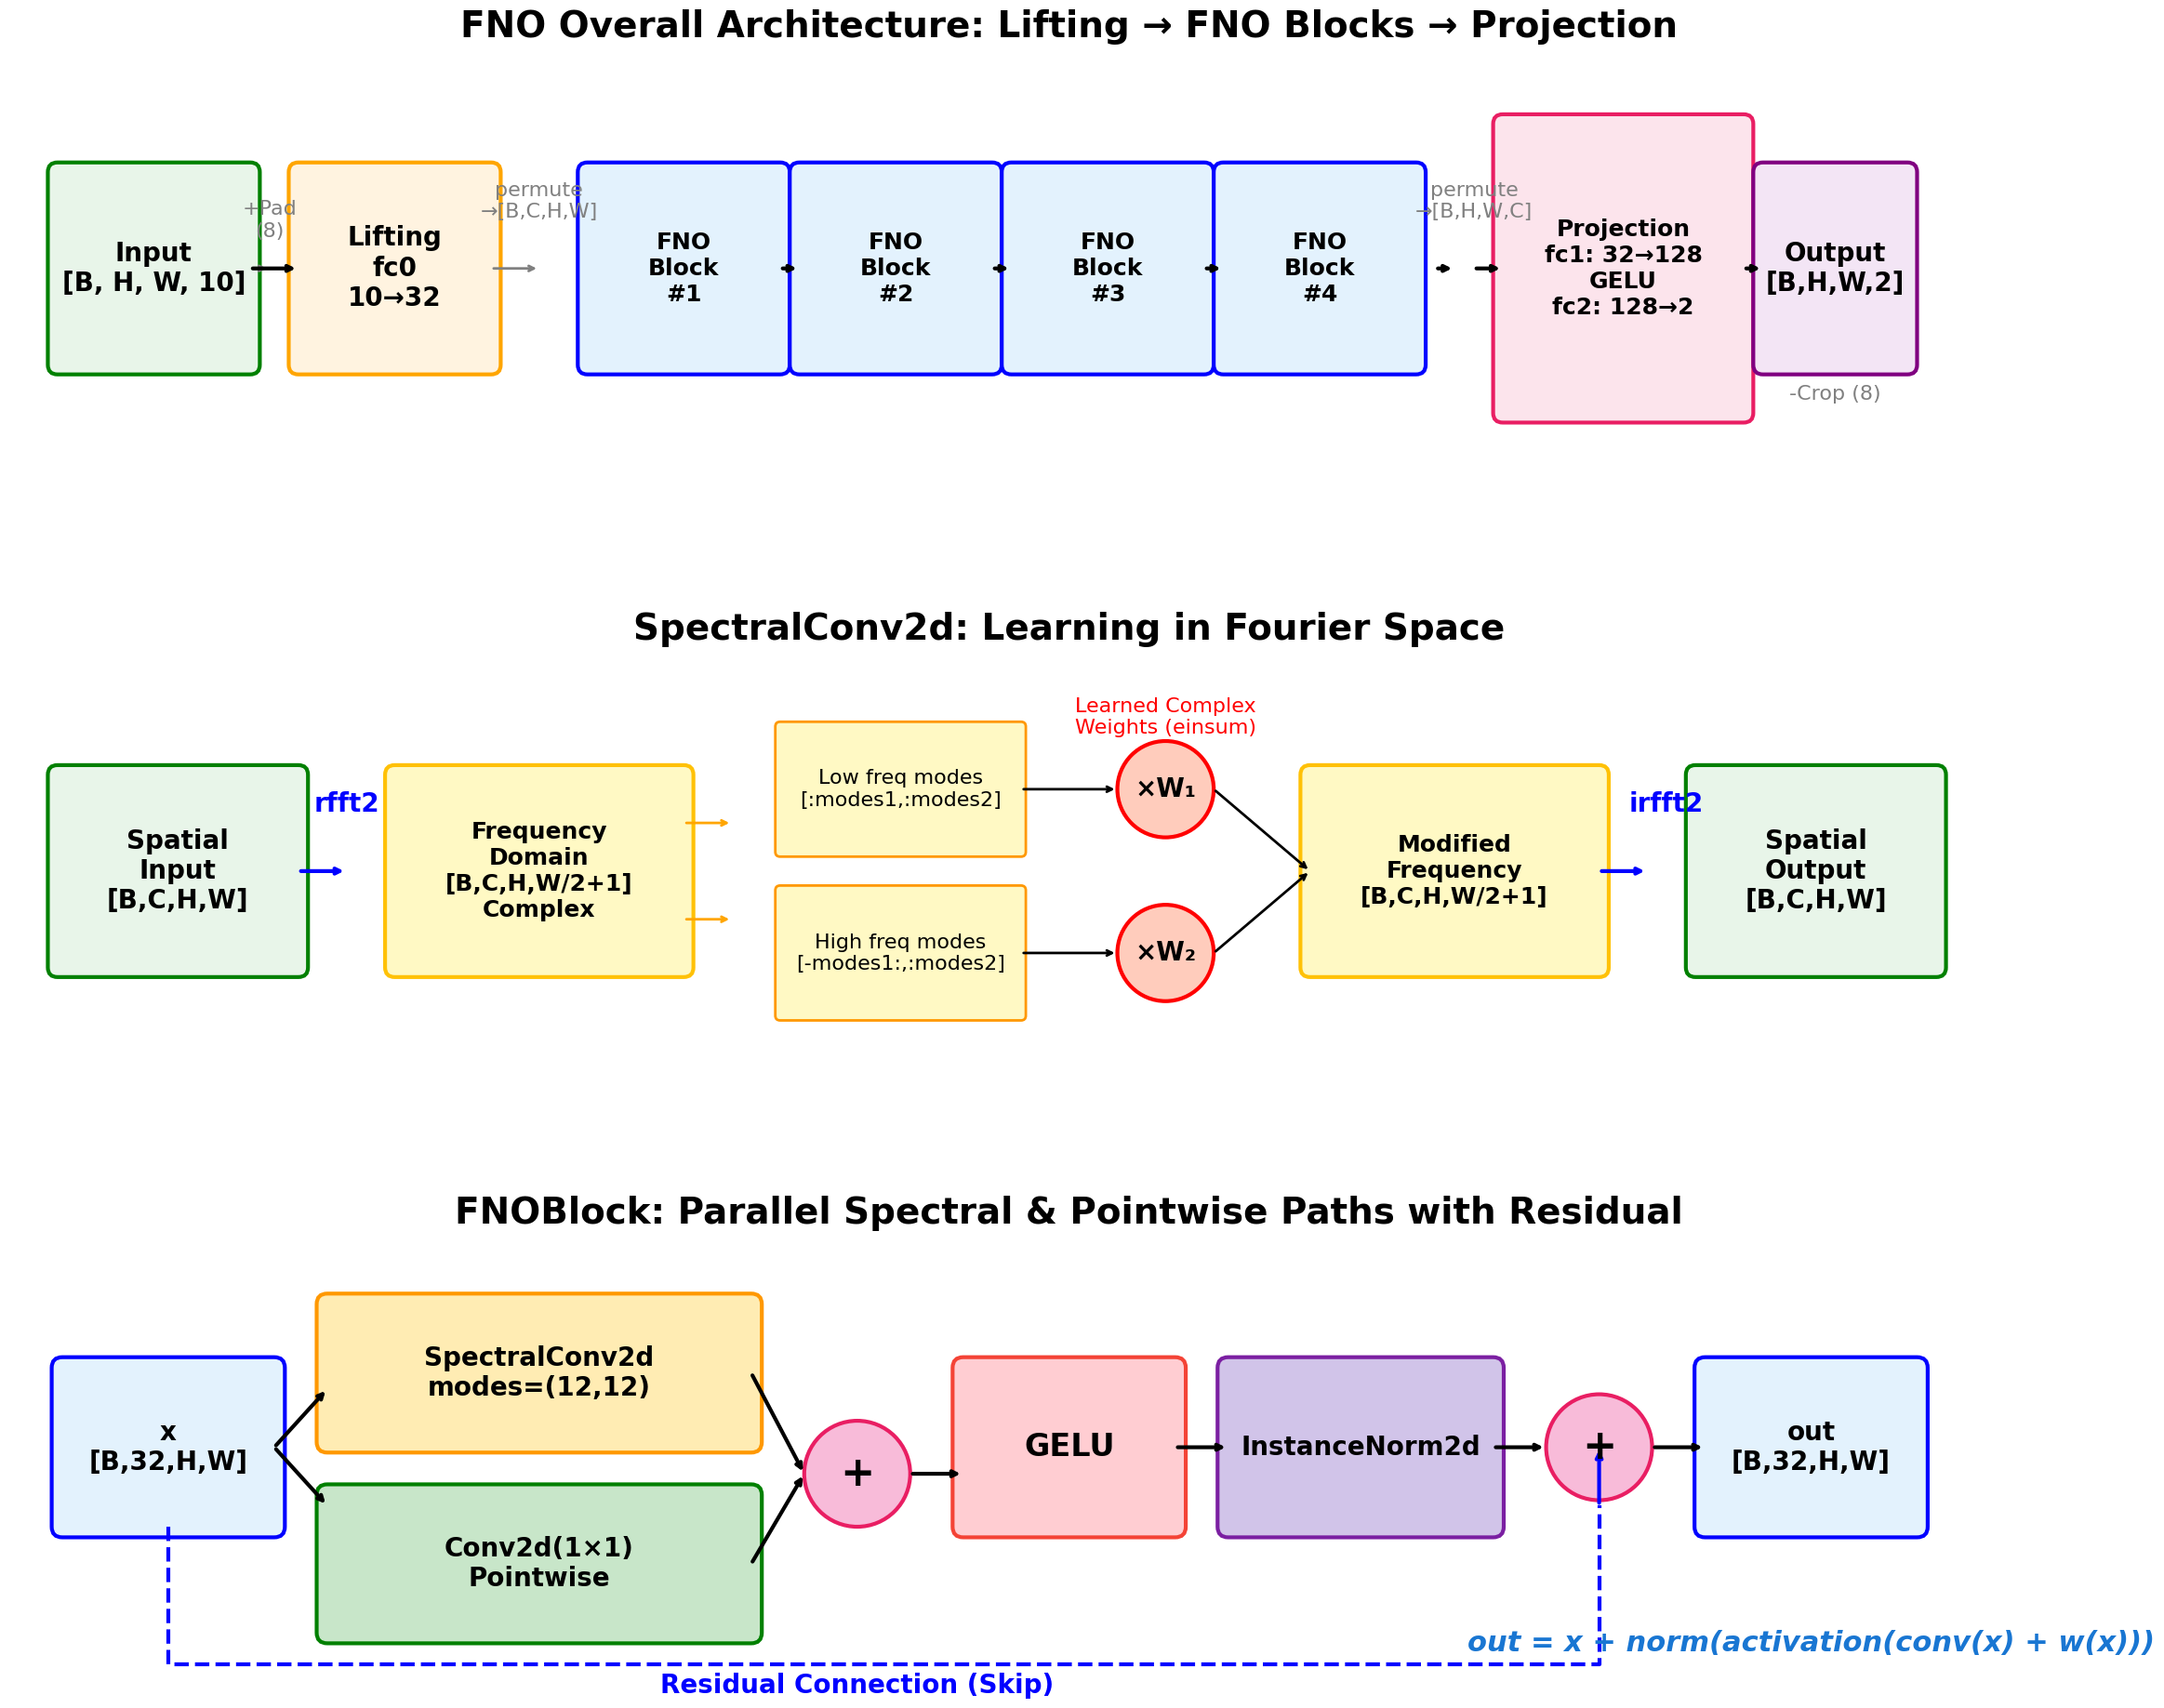

FNO architecture diagram saved to 'fno_architecture.png'


In [25]:
# ========================================
# FNO Architecture Visualization with Matplotlib
# ========================================

def draw_fno_architecture(figsize=(24, 20)):
    """
    Draw complete FNO architecture diagram with three parts:
    1. Overall FNO Pipeline (top)
    2. SpectralConv2d Detail (middle)
    3. FNOBlock Internal Structure (bottom)
    """
    fig = plt.figure(figsize=figsize)
    
    # ========================================
    # Part 1: Overall FNO Pipeline (top section)
    # ========================================
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.set_xlim(0, 22)
    ax1.set_ylim(0, 4)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title('FNO Overall Architecture: Lifting → FNO Blocks → Projection', fontsize=28, fontweight='bold', pad=30)
    
    # Colors
    input_color = '#E8F5E9'      # Light green
    lifting_color = '#FFF3E0'    # Light orange
    fno_color = '#E3F2FD'        # Light blue
    proj_color = '#FCE4EC'       # Light pink
    output_color = '#F3E5F5'     # Light purple
    
    # Input block
    ax1.add_patch(patches.FancyBboxPatch((0.5, 1), 2, 2, boxstyle="round,pad=0.1", 
                                          facecolor=input_color, edgecolor='green', linewidth=3))
    ax1.text(1.5, 2, 'Input\n[B, H, W, 10]', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Padding indicator
    ax1.annotate('', xy=(2.7, 2), xytext=(2.5, 2), 
                 arrowprops=dict(arrowstyle='->', color='gray', lw=2))
    ax1.text(2.7, 2.5, '+Pad\n(8)', ha='center', va='center', fontsize=16, color='gray')
    
    # Lifting (fc0)
    ax1.add_patch(patches.FancyBboxPatch((3, 1), 2, 2, boxstyle="round,pad=0.1", 
                                          facecolor=lifting_color, edgecolor='orange', linewidth=3))
    ax1.text(4, 2, 'Lifting\nfc0\n10→32', ha='center', va='center', fontsize=20, fontweight='bold')
    ax1.annotate('', xy=(3, 2), xytext=(2.5, 2), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Permute
    ax1.annotate('', xy=(5.5, 2), xytext=(5, 2), 
                 arrowprops=dict(arrowstyle='->', color='gray', lw=2))
    ax1.text(5.5, 2.7, 'permute\n→[B,C,H,W]', ha='center', va='center', fontsize=16, color='gray')
    
    # FNO Blocks (×4)
    for i in range(4):
        x_pos = 6 + i * 2.2
        ax1.add_patch(patches.FancyBboxPatch((x_pos, 1), 2, 2, boxstyle="round,pad=0.1", 
                                              facecolor=fno_color, edgecolor='blue', linewidth=3))
        ax1.text(x_pos + 1, 2, f'FNO\nBlock\n#{i+1}', ha='center', va='center', fontsize=18, fontweight='bold')
        if i > 0:
            ax1.annotate('', xy=(x_pos, 2), xytext=(x_pos - 0.2, 2), 
                         arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Arrow to projection
    ax1.annotate('', xy=(15, 2), xytext=(14.8, 2), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Permute back
    ax1.text(15.2, 2.7, 'permute\n→[B,H,W,C]', ha='center', va='center', fontsize=16, color='gray')
    
    # Projection (fc1 + fc2)
    ax1.add_patch(patches.FancyBboxPatch((15.5, 0.5), 2.5, 3, boxstyle="round,pad=0.1", 
                                          facecolor=proj_color, edgecolor='#E91E63', linewidth=3))
    ax1.text(16.75, 2, 'Projection\nfc1: 32→128\nGELU\nfc2: 128→2', ha='center', va='center', fontsize=18, fontweight='bold')
    ax1.annotate('', xy=(15.5, 2), xytext=(15.2, 2), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Output
    ax1.add_patch(patches.FancyBboxPatch((18.2, 1), 1.5, 2, boxstyle="round,pad=0.1", 
                                          facecolor=output_color, edgecolor='purple', linewidth=3))
    ax1.text(18.95, 2, 'Output\n[B,H,W,2]', ha='center', va='center', fontsize=20, fontweight='bold')
    ax1.annotate('', xy=(18.2, 2), xytext=(18, 2), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Crop indicator
    ax1.text(18.95, 0.7, '-Crop (8)', ha='center', va='center', fontsize=16, color='gray')
    
    # ========================================
    # Part 2: SpectralConv2d Detail (middle section)
    # ========================================
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_xlim(0, 22)
    ax2.set_ylim(0, 4)
    ax2.set_aspect('equal')
    ax2.axis('off')
    ax2.set_title('SpectralConv2d: Learning in Fourier Space', fontsize=28, fontweight='bold', pad=30)
    
    # Colors for FFT operations
    spatial_color = '#E8F5E9'
    freq_color = '#FFF9C4'       # Light yellow
    weight_color = '#FFCCBC'     # Light coral
    
    # Input spatial
    ax2.add_patch(patches.FancyBboxPatch((0.5, 1), 2.5, 2, boxstyle="round,pad=0.1", 
                                          facecolor=spatial_color, edgecolor='green', linewidth=3))
    ax2.text(1.75, 2, 'Spatial\nInput\n[B,C,H,W]', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # FFT arrow
    ax2.annotate('', xy=(3.5, 2), xytext=(3, 2), 
                 arrowprops=dict(arrowstyle='->', color='blue', lw=3))
    ax2.text(3.5, 2.7, 'rfft2', ha='center', va='center', fontsize=20, color='blue', fontweight='bold')
    
    # Frequency domain
    ax2.add_patch(patches.FancyBboxPatch((4, 1), 3, 2, boxstyle="round,pad=0.1", 
                                          facecolor=freq_color, edgecolor='#FFC107', linewidth=3))
    ax2.text(5.5, 2, 'Frequency\nDomain\n[B,C,H,W/2+1]\nComplex', ha='center', va='center', fontsize=18, fontweight='bold')
    
    # Split into modes
    ax2.annotate('', xy=(7.5, 2.5), xytext=(7, 2.5), 
                 arrowprops=dict(arrowstyle='->', color='orange', lw=2))
    ax2.annotate('', xy=(7.5, 1.5), xytext=(7, 1.5), 
                 arrowprops=dict(arrowstyle='->', color='orange', lw=2))
    
    # Low frequency modes (two branches)
    ax2.add_patch(patches.FancyBboxPatch((8, 2.2), 2.5, 1.3, boxstyle="round,pad=0.05", 
                                          facecolor=freq_color, edgecolor='#FF9800', linewidth=2))
    ax2.text(9.25, 2.85, 'Low freq modes\n[:modes1,:modes2]', ha='center', va='center', fontsize=16)
    
    ax2.add_patch(patches.FancyBboxPatch((8, 0.5), 2.5, 1.3, boxstyle="round,pad=0.05", 
                                          facecolor=freq_color, edgecolor='#FF9800', linewidth=2))
    ax2.text(9.25, 1.15, 'High freq modes\n[-modes1:,:modes2]', ha='center', va='center', fontsize=16)
    
    # Learned weights
    ax2.add_patch(patches.Circle((12, 2.85), 0.5, facecolor=weight_color, edgecolor='red', linewidth=3))
    ax2.text(12, 2.85, '×W₁', ha='center', va='center', fontsize=20, fontweight='bold')
    ax2.annotate('', xy=(11.5, 2.85), xytext=(10.5, 2.85), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    ax2.add_patch(patches.Circle((12, 1.15), 0.5, facecolor=weight_color, edgecolor='red', linewidth=3))
    ax2.text(12, 1.15, '×W₂', ha='center', va='center', fontsize=20, fontweight='bold')
    ax2.annotate('', xy=(11.5, 1.15), xytext=(10.5, 1.15), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    # Weight description
    ax2.text(12, 3.6, 'Learned Complex\nWeights (einsum)', ha='center', va='center', fontsize=16, color='red')
    
    # Combine
    ax2.annotate('', xy=(13.5, 2), xytext=(12.5, 2.85), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax2.annotate('', xy=(13.5, 2), xytext=(12.5, 1.15), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    # Output frequency
    ax2.add_patch(patches.FancyBboxPatch((13.5, 1), 3, 2, boxstyle="round,pad=0.1", 
                                          facecolor=freq_color, edgecolor='#FFC107', linewidth=3))
    ax2.text(15, 2, 'Modified\nFrequency\n[B,C,H,W/2+1]', ha='center', va='center', fontsize=18, fontweight='bold')
    
    # IFFT arrow
    ax2.annotate('', xy=(17, 2), xytext=(16.5, 2), 
                 arrowprops=dict(arrowstyle='->', color='blue', lw=3))
    ax2.text(17.2, 2.7, 'irfft2', ha='center', va='center', fontsize=20, color='blue', fontweight='bold')
    
    # Output spatial
    ax2.add_patch(patches.FancyBboxPatch((17.5, 1), 2.5, 2, boxstyle="round,pad=0.1", 
                                          facecolor=spatial_color, edgecolor='green', linewidth=3))
    ax2.text(18.75, 2, 'Spatial\nOutput\n[B,C,H,W]', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # ========================================
    # Part 3: FNOBlock Internal Structure (bottom section)
    # ========================================
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 4)
    ax3.set_aspect('equal')
    ax3.axis('off')
    ax3.set_title('FNOBlock: Parallel Spectral & Pointwise Paths with Residual', fontsize=28, fontweight='bold', pad=30)
    
    # Colors
    input_color = '#E3F2FD'
    spectral_color = '#FFECB3'
    pointwise_color = '#C8E6C9'
    add_color = '#F8BBD9'
    norm_color = '#D1C4E9'
    
    # Input
    ax3.add_patch(patches.FancyBboxPatch((0.5, 1.5), 2, 1.5, boxstyle="round,pad=0.1", 
                                          facecolor=input_color, edgecolor='blue', linewidth=3))
    ax3.text(1.5, 2.25, 'x\n[B,32,H,W]', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Fork into two paths
    ax3.annotate('', xy=(3, 2.8), xytext=(2.5, 2.25), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    ax3.annotate('', xy=(3, 1.7), xytext=(2.5, 2.25), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Spectral Conv path (top)
    ax3.add_patch(patches.FancyBboxPatch((3, 2.3), 4, 1.3, boxstyle="round,pad=0.1", 
                                          facecolor=spectral_color, edgecolor='#FF9800', linewidth=3))
    ax3.text(5, 2.95, 'SpectralConv2d\nmodes=(12,12)', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Pointwise Conv path (bottom)
    ax3.add_patch(patches.FancyBboxPatch((3, 0.5), 4, 1.3, boxstyle="round,pad=0.1", 
                                          facecolor=pointwise_color, edgecolor='green', linewidth=3))
    ax3.text(5, 1.15, 'Conv2d(1×1)\nPointwise', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Merge (addition)
    ax3.annotate('', xy=(7.5, 2), xytext=(7, 2.95), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    ax3.annotate('', xy=(7.5, 2), xytext=(7, 1.15), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    ax3.add_patch(patches.Circle((8, 2), 0.5, facecolor=add_color, edgecolor='#E91E63', linewidth=3))
    ax3.text(8, 2, '+', ha='center', va='center', fontsize=32, fontweight='bold')
    
    # Activation (GELU)
    ax3.add_patch(patches.FancyBboxPatch((9, 1.5), 2, 1.5, boxstyle="round,pad=0.1", 
                                          facecolor='#FFCDD2', edgecolor='#F44336', linewidth=3))
    ax3.text(10, 2.25, 'GELU', ha='center', va='center', fontsize=24, fontweight='bold')
    ax3.annotate('', xy=(9, 2), xytext=(8.5, 2), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Instance Norm
    ax3.add_patch(patches.FancyBboxPatch((11.5, 1.5), 2.5, 1.5, boxstyle="round,pad=0.1", 
                                          facecolor=norm_color, edgecolor='#7B1FA2', linewidth=3))
    ax3.text(12.75, 2.25, 'InstanceNorm2d', ha='center', va='center', fontsize=20, fontweight='bold')
    ax3.annotate('', xy=(11.5, 2.25), xytext=(11, 2.25), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Residual connection
    ax3.annotate('', xy=(14.5, 2.25), xytext=(14, 2.25), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Residual bypass (from input)
    ax3.plot([1.5, 1.5, 15, 15], [1.5, 0.2, 0.2, 1.7], 'b--', linewidth=3)
    ax3.annotate('', xy=(15, 2.25), xytext=(15, 1.7), 
                 arrowprops=dict(arrowstyle='->', color='blue', lw=3))
    ax3.text(8, 0, 'Residual Connection (Skip)', ha='center', va='center', fontsize=20, color='blue', fontweight='bold')
    
    # Final addition
    ax3.add_patch(patches.Circle((15, 2.25), 0.5, facecolor=add_color, edgecolor='#E91E63', linewidth=3))
    ax3.text(15, 2.25, '+', ha='center', va='center', fontsize=32, fontweight='bold')
    
    # Output
    ax3.add_patch(patches.FancyBboxPatch((16, 1.5), 2, 1.5, boxstyle="round,pad=0.1", 
                                          facecolor=input_color, edgecolor='blue', linewidth=3))
    ax3.text(17, 2.25, 'out\n[B,32,H,W]', ha='center', va='center', fontsize=20, fontweight='bold')
    ax3.annotate('', xy=(16, 2.25), xytext=(15.5, 2.25), 
                 arrowprops=dict(arrowstyle='->', color='black', lw=3))
    
    # Formula annotation
    ax3.text(17, 0.4, 'out = x + norm(activation(conv(x) + w(x)))', 
             ha='center', va='center', fontsize=22, fontweight='bold', 
             style='italic', color='#1976D2')
    
    plt.tight_layout()
    plt.savefig('fno_architecture.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("FNO architecture diagram saved to 'fno_architecture.png'")

# Draw the FNO architecture
draw_fno_architecture()

FNO Model Configuration
Input channels:  10 (u, v, sdf, log_rho, log_mu, vel_bc, geom×4)
Output channels: 2 (u, v)
Width (hidden):  32
Fourier modes:   12 × 12
Number of FNO blocks: 4
Padding: 8

Parameter Count by Component
Lifting (fc0: 10→32):        352 params
FNO Block 1:
  - SpectralConv2d:           294,912 params
  - Pointwise Conv2d(1×1):    1,056 params
  - InstanceNorm2d:           0 params
  - Block Total:              295,968 params
FNO Block 2:
  - SpectralConv2d:           294,912 params
  - Pointwise Conv2d(1×1):    1,056 params
  - InstanceNorm2d:           0 params
  - Block Total:              295,968 params
FNO Block 3:
  - SpectralConv2d:           294,912 params
  - Pointwise Conv2d(1×1):    1,056 params
  - InstanceNorm2d:           0 params
  - Block Total:              295,968 params
FNO Block 4:
  - SpectralConv2d:           294,912 params
  - Pointwise Conv2d(1×1):    1,056 params
  - InstanceNorm2d:           0 params
  - Block Total:              295,968 pa

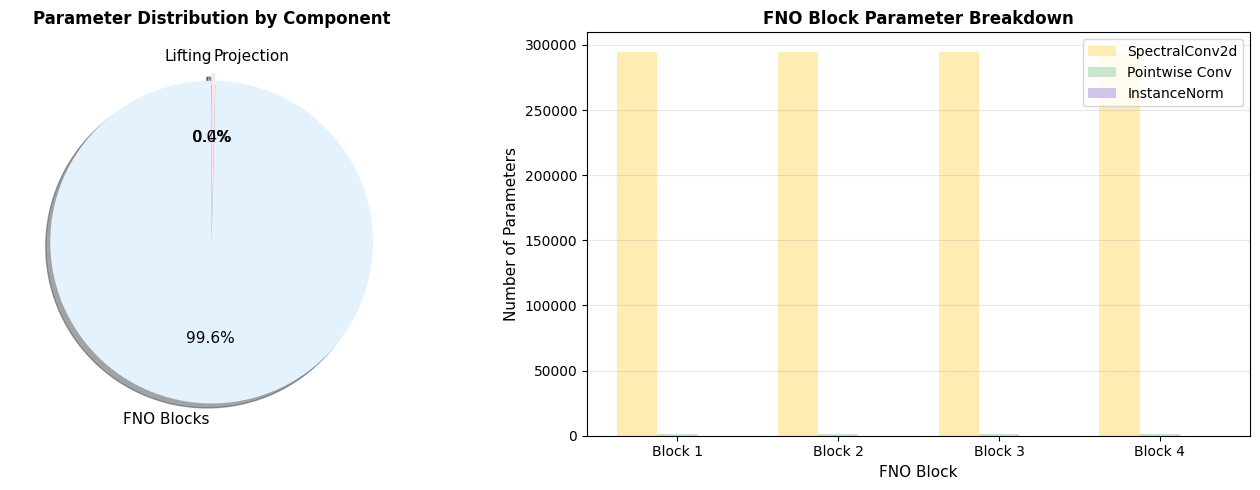


Parameter statistics saved to 'fno_parameters.png'


In [26]:
# ========================================
# FNO 参数统计与模型摘要
# ========================================

from torchsummary import summary

# Create FNO model instance with default parameters
fno_model = FNO(
    in_channels=10,
    out_channels=2,
    width=32,
    modes1=12,
    modes2=12,
    n_layers=4,
    padding=8
)

print("=" * 60)
print("FNO Model Configuration")
print("=" * 60)
print(f"Input channels:  10 (u, v, sdf, log_rho, log_mu, vel_bc, geom×4)")
print(f"Output channels: 2 (u, v)")
print(f"Width (hidden):  32")
print(f"Fourier modes:   12 × 12")
print(f"Number of FNO blocks: 4")
print(f"Padding: 8")
print()

# Count parameters by component
def count_params(module):
    return sum(p.numel() for p in module.parameters())

print("=" * 60)
print("Parameter Count by Component")
print("=" * 60)

# Lifting layer
lifting_params = count_params(fno_model.fc0)
print(f"Lifting (fc0: 10→32):        {lifting_params:,} params")

# Each FNO block
total_fno_block_params = 0
for i, block in enumerate(fno_model.fno_blocks):
    spectral_params = count_params(block.conv)
    pointwise_params = count_params(block.w)
    norm_params = count_params(block.norm)
    block_total = spectral_params + pointwise_params + norm_params
    total_fno_block_params += block_total
    print(f"FNO Block {i+1}:")
    print(f"  - SpectralConv2d:           {spectral_params:,} params")
    print(f"  - Pointwise Conv2d(1×1):    {pointwise_params:,} params")
    print(f"  - InstanceNorm2d:           {norm_params:,} params")
    print(f"  - Block Total:              {block_total:,} params")

# Projection layers
proj1_params = count_params(fno_model.fc1)
proj2_params = count_params(fno_model.fc2)
print(f"Projection (fc1: 32→128):    {proj1_params:,} params")
print(f"Projection (fc2: 128→2):     {proj2_params:,} params")

print()
print("=" * 60)
total_params = count_params(fno_model)
trainable_params = sum(p.numel() for p in fno_model.parameters() if p.requires_grad)
print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size (float32): {total_params * 4 / 1024 / 1024:.2f} MB")
print("=" * 60)

# Breakdown pie chart
print()
print("Creating parameter distribution visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart for main components
components = ['Lifting', 'FNO Blocks', 'Projection']
sizes = [lifting_params, total_fno_block_params, proj1_params + proj2_params]
colors = ['#FFF3E0', '#E3F2FD', '#FCE4EC']
explode = (0, 0.05, 0)

axes[0].pie(sizes, explode=explode, labels=components, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('Parameter Distribution by Component', fontsize=12, fontweight='bold')

# Bar chart for FNO block breakdown
block_labels = ['Block 1', 'Block 2', 'Block 3', 'Block 4']
spectral_vals = []
pointwise_vals = []
norm_vals = []

for block in fno_model.fno_blocks:
    spectral_vals.append(count_params(block.conv))
    pointwise_vals.append(count_params(block.w))
    norm_vals.append(count_params(block.norm))

x = np.arange(len(block_labels))
width = 0.25

bars1 = axes[1].bar(x - width, spectral_vals, width, label='SpectralConv2d', color='#FFECB3')
bars2 = axes[1].bar(x, pointwise_vals, width, label='Pointwise Conv', color='#C8E6C9')
bars3 = axes[1].bar(x + width, norm_vals, width, label='InstanceNorm', color='#D1C4E9')

axes[1].set_xlabel('FNO Block', fontsize=11)
axes[1].set_ylabel('Number of Parameters', fontsize=11)
axes[1].set_title('FNO Block Parameter Breakdown', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(block_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fno_parameters.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nParameter statistics saved to 'fno_parameters.png'")

## Model Comparison: PDE Ground Truth vs FNO vs UNet (Cylinder Geometry)

This section compares three approaches for predicting fluid flow past a cylinder:

1. **PDE Ground Truth**: Direct numerical simulation (CFDBench data)
2. **FNO (Fourier Neural Operator)**: Learning in Fourier space
3. **UNet**: Convolutional encoder-decoder architecture

### Comparison Metrics:
- Flow field visualization at different timesteps
- Velocity magnitude comparison (|v| = √(u² + v²))
- Computational time for inference
- L2 error relative to ground truth

In [27]:
# ========================================
# Setup: Load models, data and helper functions
# ========================================

import sys
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from pathlib import Path
import json
import time

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# ========================================
# Load cylinder case data directly
# ========================================

def load_cylinder_case(case_path):
    """Load a single cylinder case (u, v, metadata)."""
    case_path = Path(case_path)
    
    u = np.load(case_path / 'u.npy').astype(np.float32)  # [T, H, W]
    v = np.load(case_path / 'v.npy').astype(np.float32)  # [T, H, W]
    
    with open(case_path / 'case.json', 'r') as f:
        metadata = json.load(f)
    
    return u, v, metadata

def compute_sdf_cylinder(metadata, grid_size=64):
    """Compute signed distance function for cylinder."""
    x_min, x_max = metadata['x_min'], metadata['x_max']
    y_min, y_max = metadata['y_min'], metadata['y_max']
    radius = metadata['radius']
    
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x, y, indexing='xy')
    
    sdf = np.sqrt(X**2 + Y**2) - radius
    domain_scale = max(x_max - x_min, y_max - y_min)
    sdf = sdf / domain_scale
    
    return sdf.astype(np.float32)

def prepare_input_fno(u_t, v_t, metadata, grid_size=64):
    """Prepare input tensor for FNO model.
    
    FNO input: [B, H, W, 10]
    Channels: u, v, sdf, log_rho, log_mu, vel_bc, geom_onehot(4)
    """
    H, W = grid_size, grid_size
    
    # Compute SDF
    sdf = compute_sdf_cylinder(metadata, grid_size)
    
    # Physical parameters (as spatial fields)
    rho = metadata.get('density', 1.0)
    mu = metadata.get('viscosity', 0.01)
    vel_in = metadata.get('vel_in', 0.0)
    
    log_rho = np.full((H, W), np.log10(rho + 1e-8), dtype=np.float32)
    log_mu = np.full((H, W), np.log10(mu + 1e-10), dtype=np.float32)
    vel_bc = np.full((H, W), vel_in, dtype=np.float32)
    
    # Geometry one-hot: [cylinder, cavity, dam, tube]
    geom_onehot = [
        np.ones((H, W), dtype=np.float32),   # cylinder = 1
        np.zeros((H, W), dtype=np.float32),  # cavity = 0
        np.zeros((H, W), dtype=np.float32),  # dam = 0
        np.zeros((H, W), dtype=np.float32),  # tube = 0
    ]
    
    # Stack: [H, W, 10]
    x = np.stack([u_t, v_t, sdf, log_rho, log_mu, vel_bc] + geom_onehot, axis=-1)
    
    return torch.from_numpy(x).unsqueeze(0)  # [1, H, W, 10]

def prepare_input_unet(u_t, v_t, metadata, grid_size=64):
    """Prepare input tensor for UNet model.
    
    UNet input: [B, 11, H, W]
    Channels: u, v, sdf, log_rho, log_mu, vel_bc, geom_onehot(4), mask
    """
    H, W = grid_size, grid_size
    
    # Same as FNO but permuted
    sdf = compute_sdf_cylinder(metadata, grid_size)
    
    rho = metadata.get('density', 1.0)
    mu = metadata.get('viscosity', 0.01)
    vel_in = metadata.get('vel_in', 0.0)
    
    log_rho = np.full((H, W), np.log10(rho + 1e-8), dtype=np.float32)
    log_mu = np.full((H, W), np.log10(mu + 1e-10), dtype=np.float32)
    vel_bc = np.full((H, W), vel_in, dtype=np.float32)
    
    geom_onehot = [
        np.ones((H, W), dtype=np.float32),
        np.zeros((H, W), dtype=np.float32),
        np.zeros((H, W), dtype=np.float32),
        np.zeros((H, W), dtype=np.float32),
    ]
    
    # Mask: 1 inside domain, 0 inside cylinder
    mask = (sdf > 0).astype(np.float32)
    
    # Stack: [11, H, W]
    channels = [u_t, v_t, sdf, log_rho, log_mu, vel_bc] + geom_onehot + [mask]
    x = np.stack(channels, axis=0)
    
    return torch.from_numpy(x).unsqueeze(0), torch.from_numpy(mask).unsqueeze(0)  # [1, 11, H, W], [1, H, W]

# Test data loading
cylinder_data_path = Path('../..') / 'CFDBench' / 'cylinder' / 'geo' / 'case0001'
if cylinder_data_path.exists():
    u_data, v_data, meta = load_cylinder_case(cylinder_data_path)
    print(f"✅ Loaded cylinder case: u shape={u_data.shape}, v shape={v_data.shape}")
    print(f"   Metadata: {meta}")
else:
    print(f"❌ Data path not found: {cylinder_data_path}")
    print("   Please ensure CFDBench data is downloaded")

Using device: mps
✅ Loaded cylinder case: u shape=(2000, 64, 64), v shape=(2000, 64, 64)
   Metadata: {'vel_in': 1, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.02, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}


In [28]:
# ========================================
# Load Pre-trained Models
# ========================================

# --- FNO Model (already defined in previous cells) ---
# Re-instantiate with correct parameters and load weights

fno_model_viz = FNO(
    in_channels=10,
    out_channels=2,
    width=32,
    modes1=12,
    modes2=12,
    n_layers=4,
    padding=8
)

# Try to load FNO weights
fno_weights_path = Path('../training/epochs/FNO_large/best_model.pt')
if fno_weights_path.exists():
    try:
        # Load on CPU first to avoid device mismatch
        state_dict = torch.load(fno_weights_path, map_location='cpu', weights_only=True)
        fno_model_viz.load_state_dict(state_dict)
        fno_model_viz = fno_model_viz.to(device)
        fno_model_viz.eval()
        print(f"✅ FNO model loaded from {fno_weights_path}")
    except Exception as e:
        print(f"⚠️ Could not load FNO weights: {e}")
        print("   Using randomly initialized FNO for demonstration")
        fno_model_viz = fno_model_viz.to(device)
        fno_model_viz.eval()
else:
    print(f"⚠️ FNO weights not found at {fno_weights_path}")
    print("   Using randomly initialized FNO for demonstration")
    fno_model_viz = fno_model_viz.to(device)
    fno_model_viz.eval()

# --- UNet Model (already defined in previous cells) ---
unet_model_viz = UNet(
    in_channels=11,
    out_channels=2,
    features=[64, 128, 256, 512],
    n_case_params=9,
    insert_case_params_at="hidden",
    bilinear=False,
    use_residual=True,
    use_output_mask=True,
)

# Try to find UNet weights
unet_weights_paths = [
    Path('../training/checkpoints/best_model.pth'),
    Path('../training/epochs/UNet/best_model.pt'),
]

unet_loaded = False
for unet_weights_path in unet_weights_paths:
    if unet_weights_path.exists():
        try:
            state_dict = torch.load(unet_weights_path, map_location='cpu', weights_only=True)
            if 'model_state_dict' in state_dict:
                state_dict = state_dict['model_state_dict']
            unet_model_viz.load_state_dict(state_dict)
            unet_model_viz = unet_model_viz.to(device)
            unet_model_viz.eval()
            print(f"✅ UNet model loaded from {unet_weights_path}")
            unet_loaded = True
            break
        except Exception as e:
            print(f"⚠️ Could not load UNet weights from {unet_weights_path}: {e}")

if not unet_loaded:
    print("⚠️ UNet weights not found, using randomly initialized UNet for demonstration")
    unet_model_viz = unet_model_viz.to(device)
    unet_model_viz.eval()

print(f"\n📊 Models ready for comparison on device: {device}")

✅ FNO model loaded from ../training/epochs/FNO_large/best_model.pt
⚠️ UNet weights not found, using randomly initialized UNet for demonstration

📊 Models ready for comparison on device: mps


/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_85225/2472654351.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.08, 0.05, 0.9, 0.96])


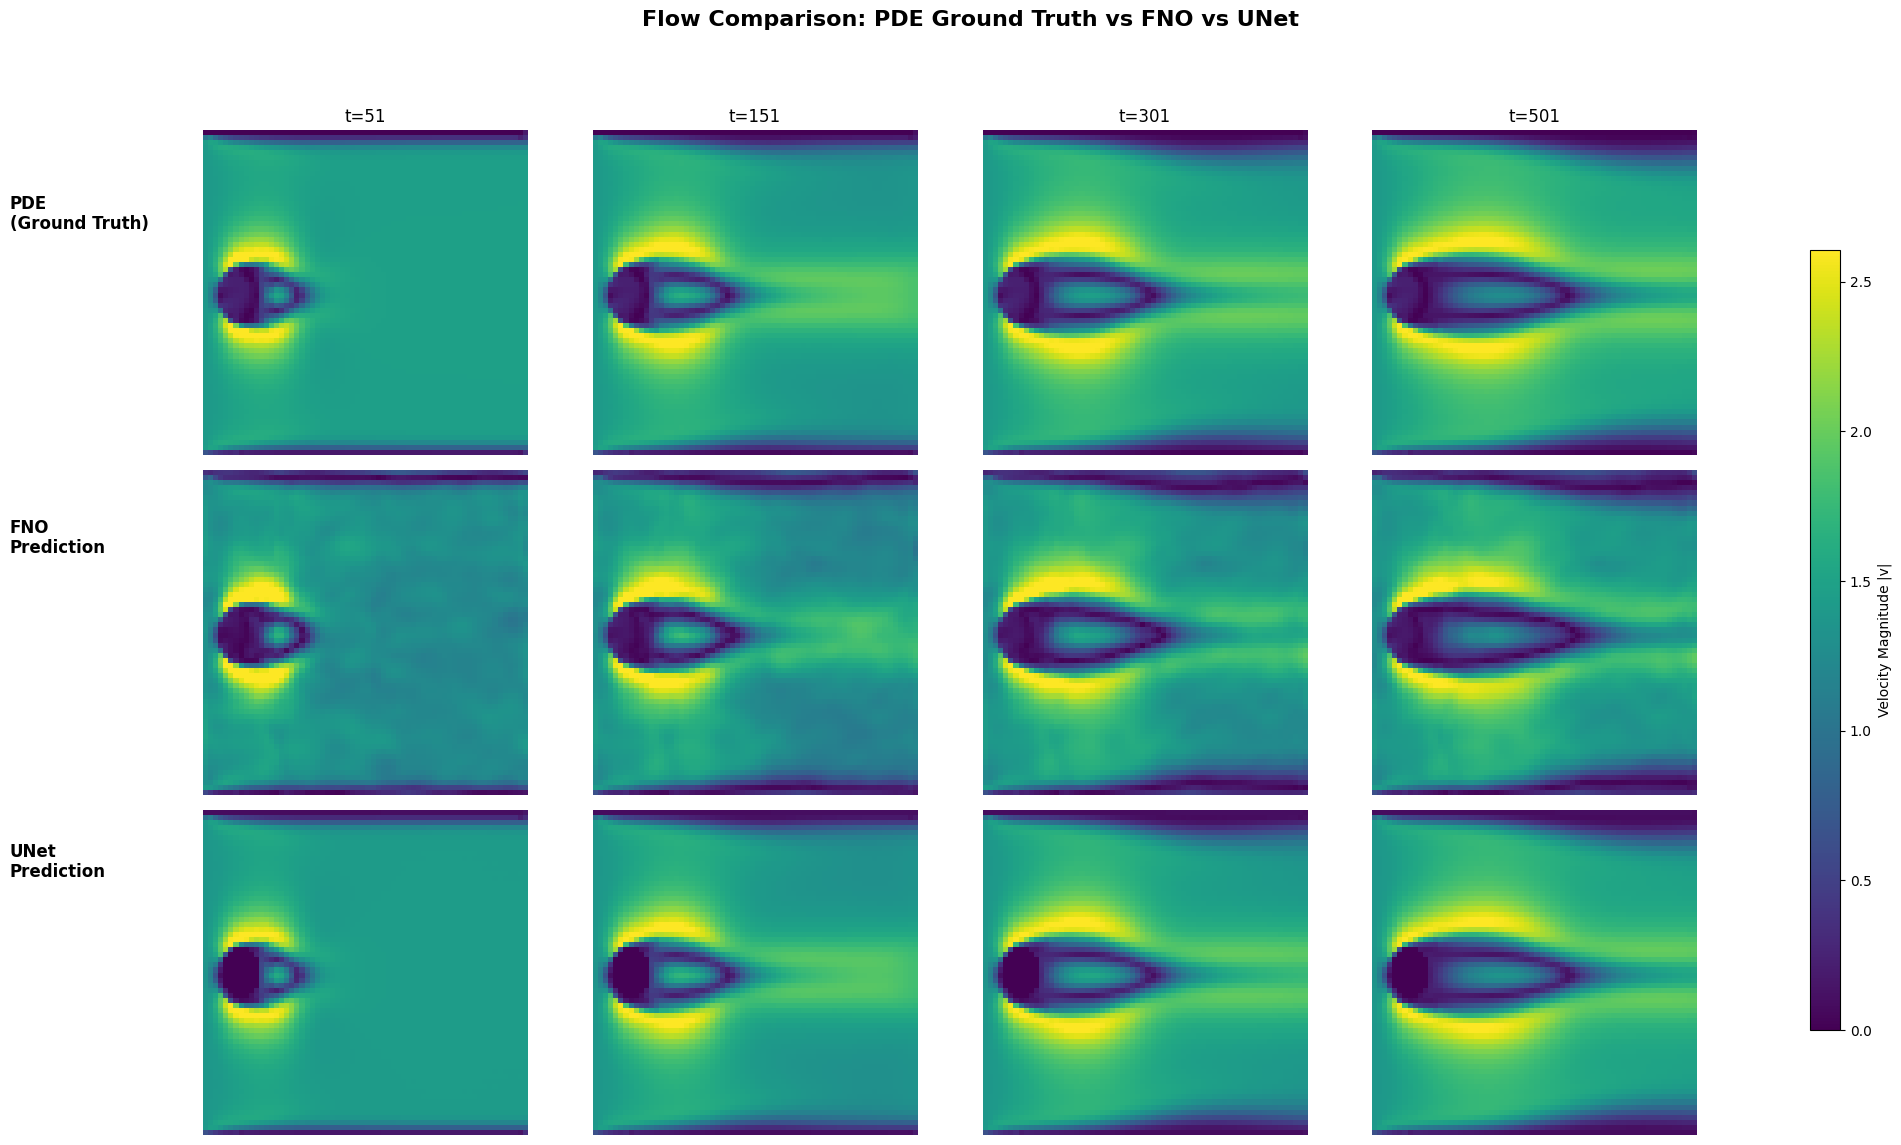

/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_85225/2472654351.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.08, 0.05, 0.9, 0.96])


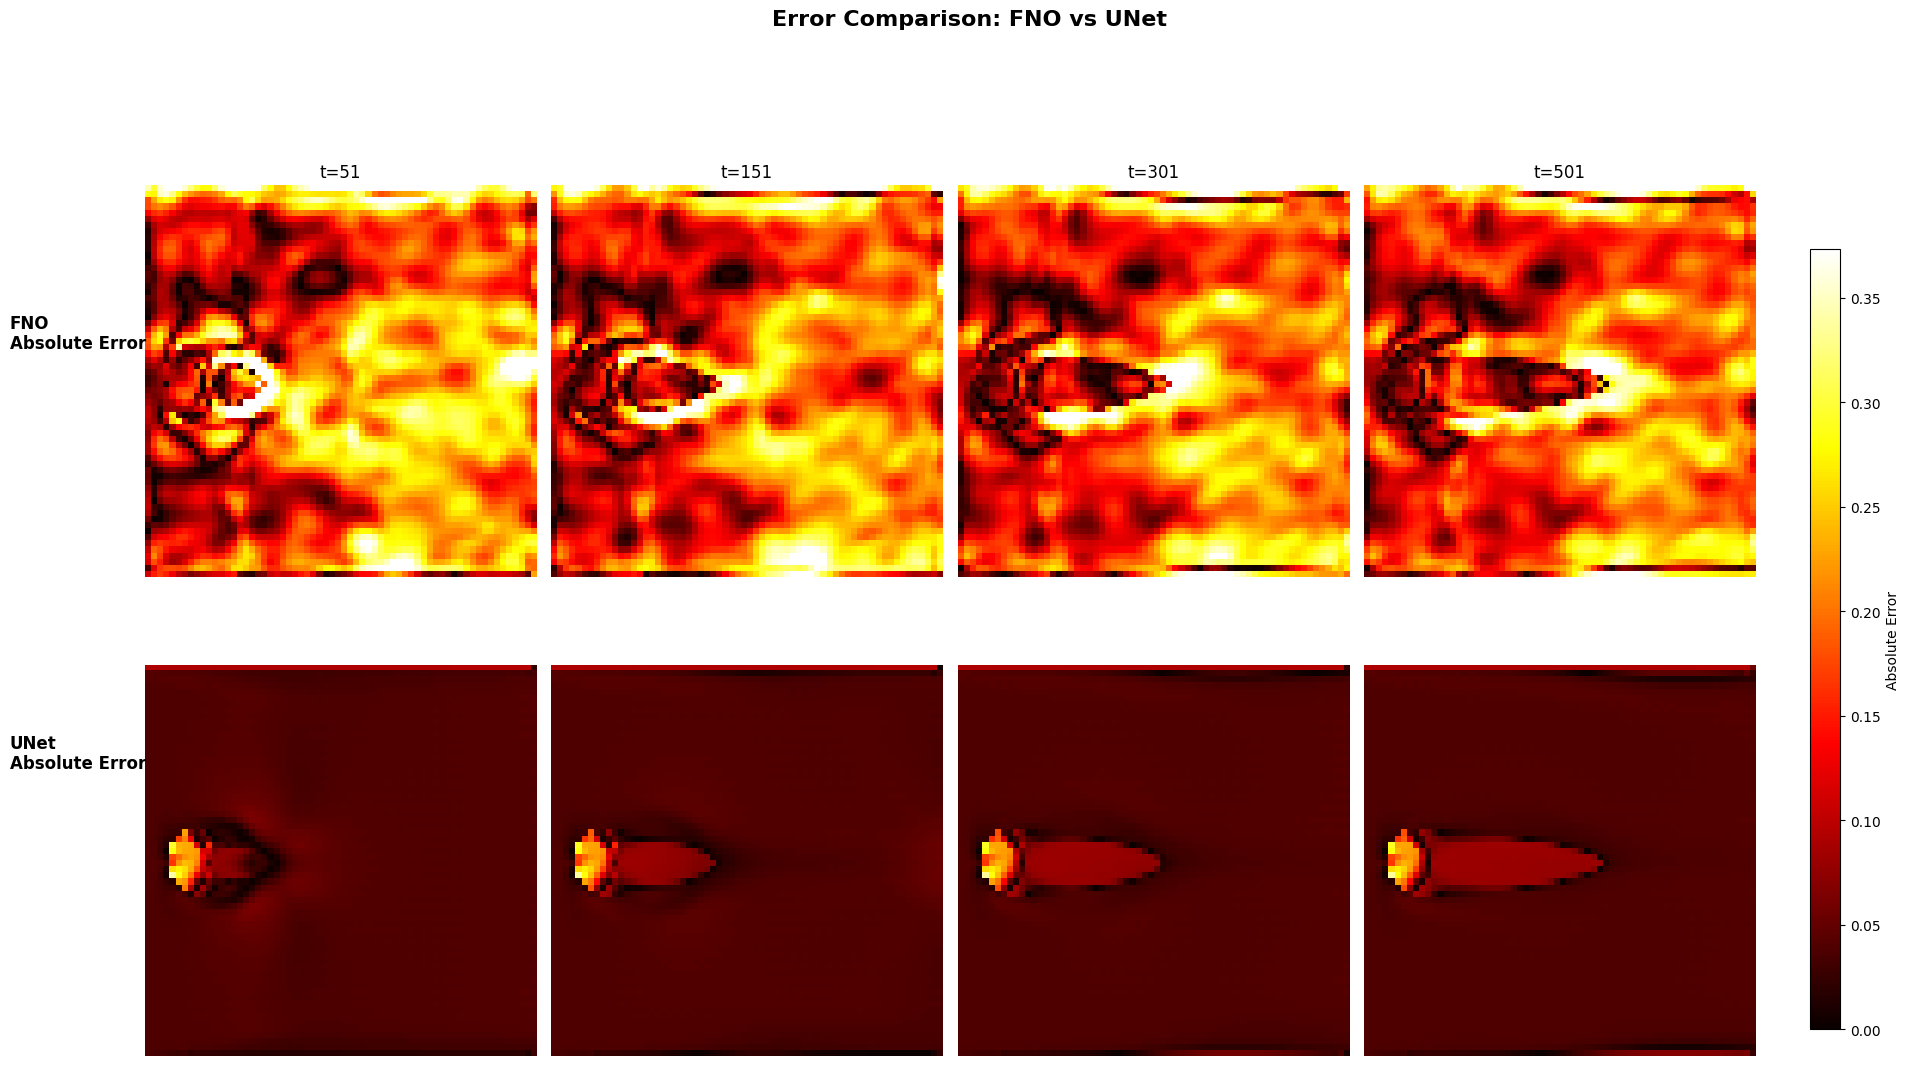


⏱️  Inference Time Comparison (single step)
FNO average: 51.183 ms
UNet average: 7.602 ms
Speedup (UNet/FNO): 0.15x


In [37]:
# ========================================
# Visualization: Compare PDE vs FNO vs UNet Results
# ========================================

def compare_models_cylinder(
    u_data, v_data, metadata,
    fno_model, unet_model,
    timesteps=[50, 100, 200, 400],
    device=device,
    figsize=(20, 12)
):
    """
    Compare PDE ground truth, FNO prediction, and UNet prediction
    for cylinder flow at multiple timesteps.
    Creates two figures: Flow Comparison (PDE, FNO, UNet) and Error Comparison.
    """
    n_times = len(timesteps)
    
    # Create figure 1: Flow Comparison (3 rows × n_times columns)
    fig, axes = plt.subplots(3, n_times, figsize=figsize)
    fig.suptitle('Flow Comparison: PDE Ground Truth vs FNO vs UNet', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Compute global colormap limits from ground truth
    all_velocities = []
    for t in timesteps:
        if t < len(u_data):
            vel_mag = np.sqrt(u_data[t]**2 + v_data[t]**2)
            all_velocities.extend(vel_mag.flatten())
    
    vmin, vmax = 0, np.percentile(all_velocities, 99)
    
    # Timing results
    fno_times = []
    unet_times = []
    
    # Prepare case params for UNet (simplified)
    case_params = torch.tensor([[
        metadata.get('vel_in', 0.0),
        np.log10(metadata.get('density', 1.0) + 1e-8),
        np.log10(metadata.get('viscosity', 0.01) + 1e-10),
        metadata.get('radius', 0.01),
        metadata.get('x_min', 0),
        metadata.get('x_max', 1),
        metadata.get('y_min', 0),
        metadata.get('y_max', 1),
        1.0  # cylinder indicator
    ]], dtype=torch.float32, device=device)
    
    # Row labels for Flow Comparison
    flow_row_labels = ['PDE\n(Ground Truth)', 'FNO\nPrediction', 'UNet\nPrediction']
    
    # Store errors for second figure
    all_fno_errors = []
    all_unet_errors = []
    all_gt_vels = []
    
    for col, t in enumerate(timesteps):
        if t >= len(u_data) - 1:
            print(f"Skipping timestep {t} (out of range)")
            continue
        
        u_t = u_data[t]
        v_t = v_data[t]
        u_gt = u_data[t + 1]  # Ground truth next step
        v_gt = v_data[t + 1]
        
        # --- Row 0: PDE Ground Truth ---
        vel_gt = np.sqrt(u_gt**2 + v_gt**2)
        im0 = axes[0, col].imshow(vel_gt, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        axes[0, col].set_title(f't={t+1}', fontsize=12)
        axes[0, col].axis('off')
        
        # --- Row 1: FNO Prediction ---
        x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
        
        with torch.no_grad():
            start_time = time.perf_counter()
            pred_fno = fno_model(x_fno)  # [1, H, W, 2]
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            fno_time = time.perf_counter() - start_time
            fno_times.append(fno_time)
        
        pred_fno_np = pred_fno.cpu().numpy()[0]  # [H, W, 2]
        u_fno = pred_fno_np[..., 0]
        v_fno = pred_fno_np[..., 1]
        vel_fno = np.sqrt(u_fno**2 + v_fno**2)
        
        im1 = axes[1, col].imshow(vel_fno, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        axes[1, col].axis('off')
        
        # --- Row 2: UNet Prediction ---
        x_unet, mask = prepare_input_unet(u_t, v_t, metadata)
        x_unet = x_unet.to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            start_time = time.perf_counter()
            pred_unet = unet_model(x_unet, case_params=case_params, mask=mask)  # [1, H, W, 2]
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            unet_time = time.perf_counter() - start_time
            unet_times.append(unet_time)
        
        pred_unet_np = pred_unet.cpu().numpy()[0]  # [H, W, 2]
        u_unet = pred_unet_np[..., 0]
        v_unet = pred_unet_np[..., 1]
        vel_unet = np.sqrt(u_unet**2 + v_unet**2)
        
        im2 = axes[2, col].imshow(vel_unet, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        axes[2, col].axis('off')
        
        # Store errors for the second figure
        err_fno = np.abs(vel_fno - vel_gt)
        err_unet = np.abs(vel_unet - vel_gt)
        all_fno_errors.append(err_fno)
        all_unet_errors.append(err_unet)
        all_gt_vels.append(vel_gt)
    
    # Add row labels on the left side of the flow figure
    for row, label in enumerate(flow_row_labels):
        y_pos = 0.83 - row * 0.27
        fig.text(0.02, y_pos, label, va='center', ha='left', 
                 fontsize=12, fontweight='bold', rotation=0)
    
    # Add colorbar for flow figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.65])
    fig.colorbar(im0, cax=cbar_ax, label='Velocity Magnitude |v|')
    
    plt.tight_layout(rect=[0.08, 0.05, 0.9, 0.96])
    plt.savefig('comparison_cylinder_flow.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Create figure 2: Error Comparison (2 rows × n_times columns)
    fig2, axes2 = plt.subplots(2, n_times, figsize=figsize)
    fig2.suptitle('Error Comparison: FNO vs UNet', 
                  fontsize=16, fontweight='bold', y=1.00)
    
    # Compute error colormap limits
    all_errors = []
    for err_fno in all_fno_errors:
        all_errors.extend(err_fno.flatten())
    for err_unet in all_unet_errors:
        all_errors.extend(err_unet.flatten())
    
    error_vmin, error_vmax = 0, np.percentile(all_errors, 99)
    
    # Row labels for Error Comparison
    error_row_labels = ['FNO\nAbsolute Error', 'UNet\nAbsolute Error']
    
    for col in range(n_times):
        # Row 0: FNO Error
        im_fno = axes2[0, col].imshow(all_fno_errors[col], cmap='hot', vmin=error_vmin, vmax=error_vmax, origin='lower')
        axes2[0, col].set_title(f't={timesteps[col]+1}', fontsize=12)
        axes2[0, col].axis('off')
        
        # Row 1: UNet Error
        im_unet = axes2[1, col].imshow(all_unet_errors[col], cmap='hot', vmin=error_vmin, vmax=error_vmax, origin='lower')
        axes2[1, col].axis('off')
    
    # Add row labels on the left side of the error figure
    for row, label in enumerate(error_row_labels):
        y_pos = 0.73 - row * 0.35
        fig2.text(0.02, y_pos, label, va='center', ha='left', 
                  fontsize=12, fontweight='bold', rotation=0)
    
    # Add colorbar for error figure
    cbar_ax2 = fig2.add_axes([0.92, 0.15, 0.015, 0.65])
    fig2.colorbar(im_fno, cax=cbar_ax2, label='Absolute Error')
    
    plt.tight_layout(rect=[0.08, 0.05, 0.9, 0.96])
    plt.savefig('comparison_cylinder_error.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("\n" + "=" * 60)
    print("⏱️  Inference Time Comparison (single step)")
    print("=" * 60)
    print(f"FNO average: {np.mean(fno_times)*1000:.3f} ms")
    print(f"UNet average: {np.mean(unet_times)*1000:.3f} ms")
    print(f"Speedup (UNet/FNO): {np.mean(unet_times)/np.mean(fno_times):.2f}x")
    print("=" * 60)
    
    return fno_times, unet_times

# Run comparison
if 'u_data' in dir() and 'v_data' in dir():
    fno_times, unet_times = compare_models_cylinder(
        u_data, v_data, meta,
        fno_model_viz, unet_model_viz,
        timesteps=[50, 150, 300, 500],
        device=device
    )
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

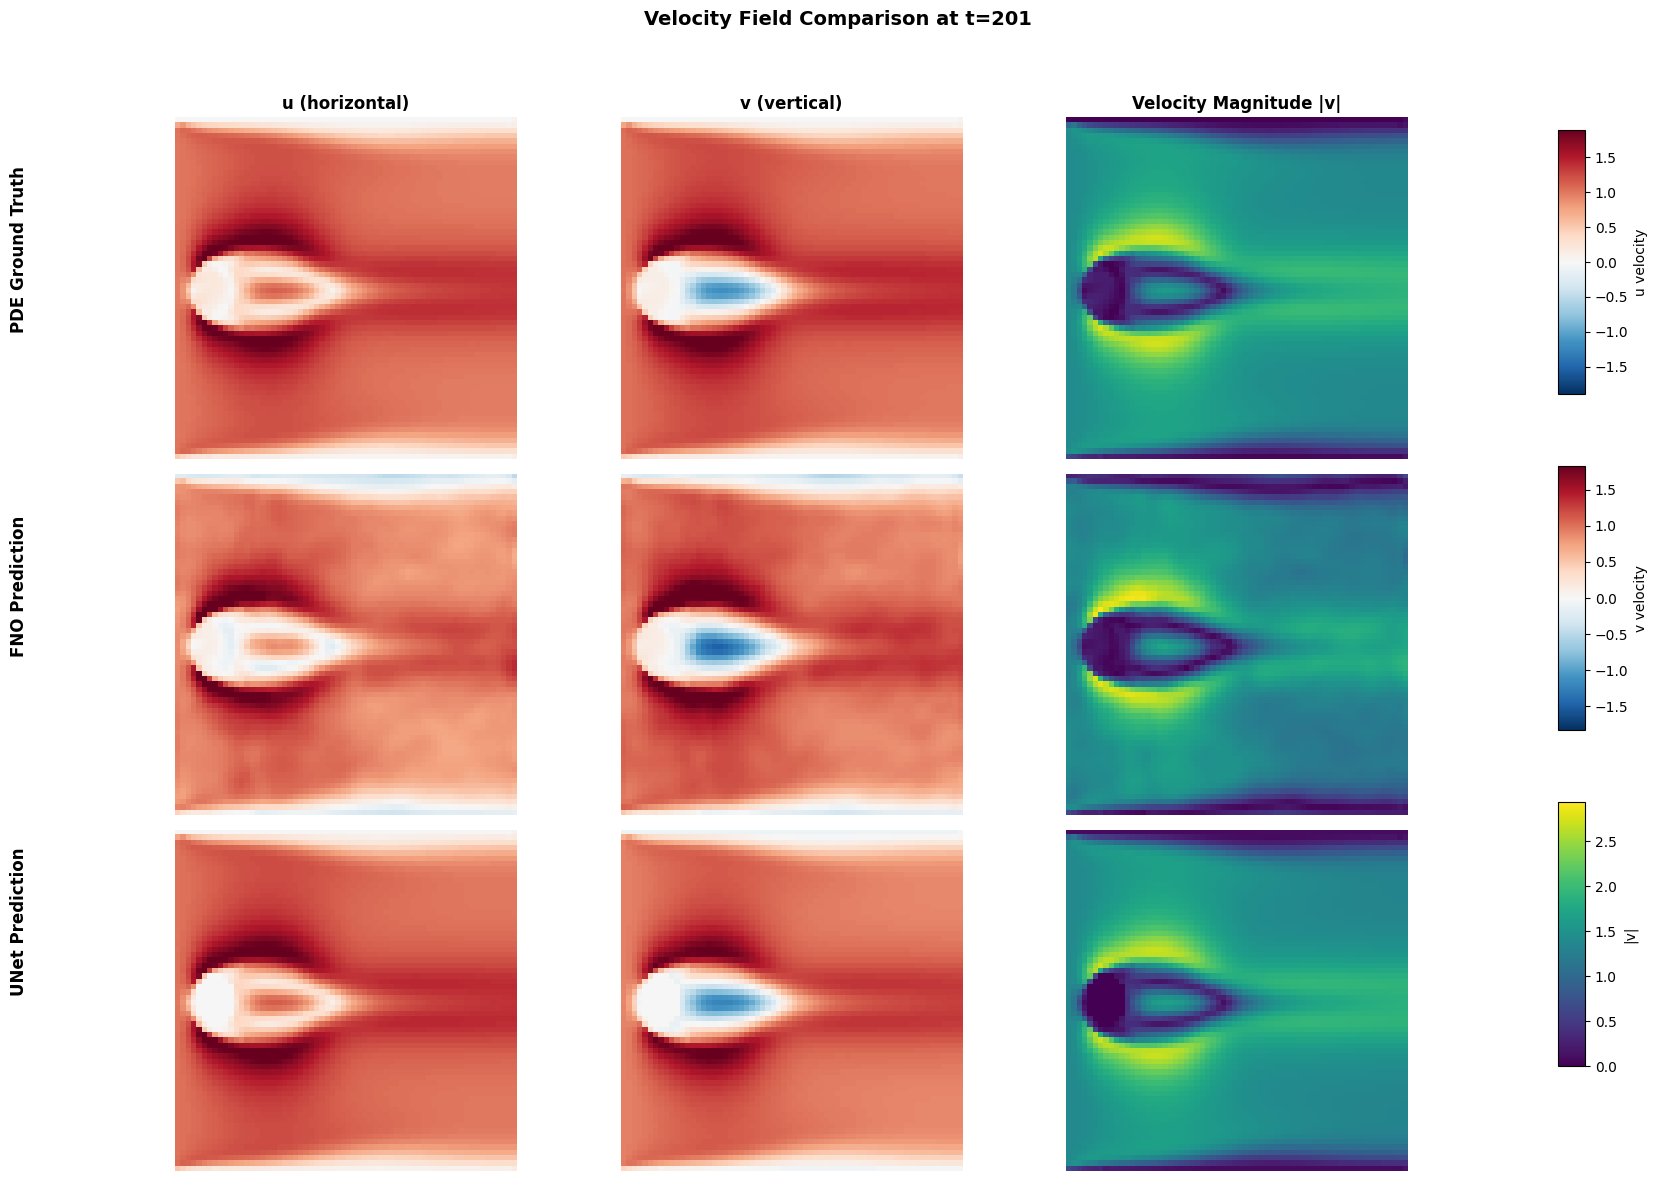


📊 L2 Error Analysis at t=201
Model      L2(u)           L2(v)           L2(total)      
------------------------------------------------------------
FNO        0.185902        0.124488        0.223734       
UNet       0.032911        0.086186        0.092256       


In [30]:
# ========================================
# Detailed Velocity Field Visualization (u and v components)
# ========================================

def visualize_velocity_components(
    u_data, v_data, metadata,
    fno_model, unet_model,
    timestep=200,
    device=device,
    figsize=(18, 12)
):
    """
    Visualize u and v velocity components separately for
    PDE Ground Truth, FNO, and UNet.
    """
    if timestep >= len(u_data) - 1:
        print(f"Timestep {timestep} out of range, using last available")
        timestep = len(u_data) - 2
    
    t = timestep
    u_t = u_data[t]
    v_t = v_data[t]
    u_gt = u_data[t + 1]
    v_gt = v_data[t + 1]
    
    # Prepare case params
    case_params = torch.tensor([[
        metadata.get('vel_in', 0.0),
        np.log10(metadata.get('density', 1.0) + 1e-8),
        np.log10(metadata.get('viscosity', 0.01) + 1e-10),
        metadata.get('radius', 0.01),
        metadata.get('x_min', 0),
        metadata.get('x_max', 1),
        metadata.get('y_min', 0),
        metadata.get('y_max', 1),
        1.0
    ]], dtype=torch.float32, device=device)
    
    # FNO prediction
    x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
    with torch.no_grad():
        pred_fno = fno_model(x_fno).cpu().numpy()[0]
    u_fno, v_fno = pred_fno[..., 0], pred_fno[..., 1]
    
    # UNet prediction
    x_unet, mask = prepare_input_unet(u_t, v_t, metadata)
    x_unet, mask = x_unet.to(device), mask.to(device)
    with torch.no_grad():
        pred_unet = unet_model(x_unet, case_params=case_params, mask=mask).cpu().numpy()[0]
    u_unet, v_unet = pred_unet[..., 0], pred_unet[..., 1]
    
    # Create figure: 3 rows (PDE, FNO, UNet) × 3 cols (u, v, |v|)
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    fig.suptitle(f'Velocity Field Comparison at t={t+1}', fontsize=14, fontweight='bold')
    
    row_labels = ['PDE Ground Truth', 'FNO Prediction', 'UNet Prediction']
    col_labels = ['u (horizontal)', 'v (vertical)', 'Velocity Magnitude |v|']
    
    data_rows = [
        (u_gt, v_gt, np.sqrt(u_gt**2 + v_gt**2)),
        (u_fno, v_fno, np.sqrt(u_fno**2 + v_fno**2)),
        (u_unet, v_unet, np.sqrt(u_unet**2 + v_unet**2)),
    ]
    
    # Compute color limits
    u_all = np.concatenate([u_gt.flatten(), u_fno.flatten(), u_unet.flatten()])
    v_all = np.concatenate([v_gt.flatten(), v_fno.flatten(), v_unet.flatten()])
    u_lim = max(abs(np.percentile(u_all, 1)), abs(np.percentile(u_all, 99)))
    v_lim = max(abs(np.percentile(v_all, 1)), abs(np.percentile(v_all, 99)))
    vel_max = np.percentile([np.sqrt(u_gt**2 + v_gt**2).max(), 
                             np.sqrt(u_fno**2 + v_fno**2).max(), 
                             np.sqrt(u_unet**2 + v_unet**2).max()], 99)
    
    for row, (u, v, vel_mag) in enumerate(data_rows):
        # u component (diverging colormap)
        im0 = axes[row, 0].imshow(u, cmap='RdBu_r', vmin=-u_lim, vmax=u_lim, origin='lower')
        axes[row, 0].axis('off')
        
        # v component (diverging colormap)
        im1 = axes[row, 1].imshow(v, cmap='RdBu_r', vmin=-v_lim, vmax=v_lim, origin='lower')
        axes[row, 1].axis('off')
        
        # Velocity magnitude
        im2 = axes[row, 2].imshow(vel_mag, cmap='viridis', vmin=0, vmax=vel_max, origin='lower')
        axes[row, 2].axis('off')
    
    # Column titles
    for col, label in enumerate(col_labels):
        axes[0, col].set_title(label, fontsize=12, fontweight='bold')
    
    # Colorbars
    plt.tight_layout(rect=[0.06, 0, 0.88, 0.95])
    
    # Add row labels using fig.text (left side)
    row_positions = [0.78, 0.50, 0.22]  # Approximate y positions for 3 rows
    for row, label in enumerate(row_labels):
        fig.text(0.05, row_positions[row], label, va='center', ha='right',
                 fontsize=12, fontweight='bold', rotation=90)
    
    # Add colorbars on the right
    fig.subplots_adjust(right=0.88)
    cbar_ax1 = fig.add_axes([0.90, 0.66, 0.015, 0.22])
    fig.colorbar(im0, cax=cbar_ax1, label='u velocity')
    
    cbar_ax2 = fig.add_axes([0.90, 0.38, 0.015, 0.22])
    fig.colorbar(im1, cax=cbar_ax2, label='v velocity')
    
    cbar_ax3 = fig.add_axes([0.90, 0.1, 0.015, 0.22])
    fig.colorbar(im2, cax=cbar_ax3, label='|v|')
    
    plt.savefig('velocity_components_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Compute L2 errors
    print("\n" + "=" * 60)
    print(f"📊 L2 Error Analysis at t={t+1}")
    print("=" * 60)
    
    l2_u_fno = np.sqrt(np.mean((u_fno - u_gt)**2))
    l2_v_fno = np.sqrt(np.mean((v_fno - v_gt)**2))
    l2_u_unet = np.sqrt(np.mean((u_unet - u_gt)**2))
    l2_v_unet = np.sqrt(np.mean((v_unet - v_gt)**2))
    
    print(f"{'Model':<10} {'L2(u)':<15} {'L2(v)':<15} {'L2(total)':<15}")
    print("-" * 60)
    print(f"{'FNO':<10} {l2_u_fno:<15.6f} {l2_v_fno:<15.6f} {np.sqrt(l2_u_fno**2 + l2_v_fno**2):<15.6f}")
    print(f"{'UNet':<10} {l2_u_unet:<15.6f} {l2_v_unet:<15.6f} {np.sqrt(l2_u_unet**2 + l2_v_unet**2):<15.6f}")
    print("=" * 60)

# Run velocity component visualization
if 'u_data' in dir() and 'v_data' in dir():
    visualize_velocity_components(
        u_data, v_data, meta,
        fno_model_viz, unet_model_viz,
        timestep=200,
        device=device
    )
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

Running inference time benchmark...


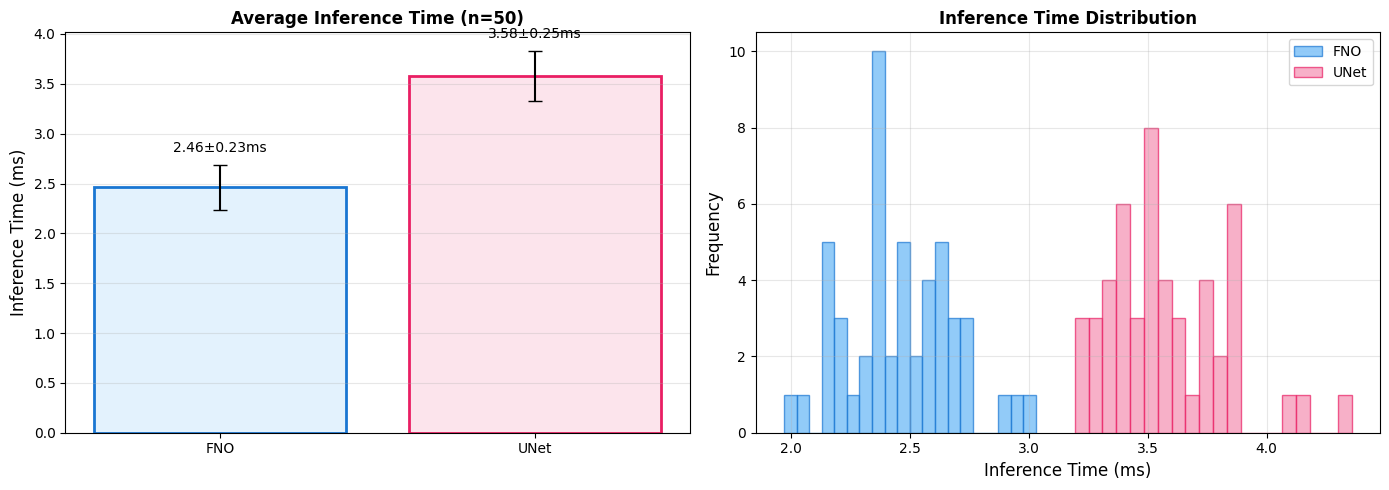


⏱️  Inference Time Benchmark Results (device: mps)
Model      Mean (ms)       Std (ms)        Min (ms)        Max (ms)       
------------------------------------------------------------
FNO        2.460           0.230           1.970           3.029          
UNet       3.577           0.248           3.193           4.358          


In [31]:
# ========================================
# Inference Time Benchmark Chart
# ========================================

def benchmark_inference_time(
    u_data, v_data, metadata,
    fno_model, unet_model,
    n_runs=50,
    device=device
):
    """
    Benchmark inference time for both models.
    """
    print("Running inference time benchmark...")
    
    t = 100  # Use a middle timestep
    u_t = u_data[t]
    v_t = v_data[t]
    
    # Prepare inputs
    x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
    x_unet, mask = prepare_input_unet(u_t, v_t, metadata)
    x_unet, mask = x_unet.to(device), mask.to(device)
    
    case_params = torch.tensor([[
        metadata.get('vel_in', 0.0),
        np.log10(metadata.get('density', 1.0) + 1e-8),
        np.log10(metadata.get('viscosity', 0.01) + 1e-10),
        metadata.get('radius', 0.01),
        metadata.get('x_min', 0),
        metadata.get('x_max', 1),
        metadata.get('y_min', 0),
        metadata.get('y_max', 1),
        1.0
    ]], dtype=torch.float32, device=device)
    
    # Warmup
    for _ in range(5):
        with torch.no_grad():
            _ = fno_model(x_fno)
            _ = unet_model(x_unet, case_params=case_params, mask=mask)
    
    if device.type == 'mps':
        torch.mps.synchronize()
    elif device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Benchmark FNO
    fno_times = []
    for _ in range(n_runs):
        if device.type == 'mps':
            torch.mps.synchronize()
        elif device.type == 'cuda':
            torch.cuda.synchronize()
        
        start = time.perf_counter()
        with torch.no_grad():
            _ = fno_model(x_fno)
        
        if device.type == 'mps':
            torch.mps.synchronize()
        elif device.type == 'cuda':
            torch.cuda.synchronize()
        fno_times.append(time.perf_counter() - start)
    
    # Benchmark UNet
    unet_times = []
    for _ in range(n_runs):
        if device.type == 'mps':
            torch.mps.synchronize()
        elif device.type == 'cuda':
            torch.cuda.synchronize()
        
        start = time.perf_counter()
        with torch.no_grad():
            _ = unet_model(x_unet, case_params=case_params, mask=mask)
        
        if device.type == 'mps':
            torch.mps.synchronize()
        elif device.type == 'cuda':
            torch.cuda.synchronize()
        unet_times.append(time.perf_counter() - start)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart comparison
    models = ['FNO', 'UNet']
    means = [np.mean(fno_times) * 1000, np.mean(unet_times) * 1000]
    stds = [np.std(fno_times) * 1000, np.std(unet_times) * 1000]
    colors = ['#E3F2FD', '#FCE4EC']
    edge_colors = ['#1976D2', '#E91E63']
    
    bars = axes[0].bar(models, means, yerr=stds, capsize=5, color=colors, edgecolor=edge_colors, linewidth=2)
    axes[0].set_ylabel('Inference Time (ms)', fontsize=12)
    axes[0].set_title(f'Average Inference Time (n={n_runs})', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, mean, std in zip(bars, means, stds):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.1,
                     f'{mean:.2f}±{std:.2f}ms', ha='center', va='bottom', fontsize=10)
    
    # Distribution plot
    axes[1].hist(np.array(fno_times) * 1000, bins=20, alpha=0.7, label='FNO', color='#64B5F6', edgecolor='#1976D2')
    axes[1].hist(np.array(unet_times) * 1000, bins=20, alpha=0.7, label='UNet', color='#F48FB1', edgecolor='#E91E63')
    axes[1].set_xlabel('Inference Time (ms)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Inference Time Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('inference_time_benchmark.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Print summary
    print("\n" + "=" * 60)
    print(f"⏱️  Inference Time Benchmark Results (device: {device})")
    print("=" * 60)
    print(f"{'Model':<10} {'Mean (ms)':<15} {'Std (ms)':<15} {'Min (ms)':<15} {'Max (ms)':<15}")
    print("-" * 60)
    print(f"{'FNO':<10} {np.mean(fno_times)*1000:<15.3f} {np.std(fno_times)*1000:<15.3f} "
          f"{np.min(fno_times)*1000:<15.3f} {np.max(fno_times)*1000:<15.3f}")
    print(f"{'UNet':<10} {np.mean(unet_times)*1000:<15.3f} {np.std(unet_times)*1000:<15.3f} "
          f"{np.min(unet_times)*1000:<15.3f} {np.max(unet_times)*1000:<15.3f}")
    print("=" * 60)
    
    return fno_times, unet_times

# Run benchmark
if 'u_data' in dir() and 'v_data' in dir():
    fno_bench, unet_bench = benchmark_inference_time(
        u_data, v_data, meta,
        fno_model_viz, unet_model_viz,
        n_runs=50,
        device=device
    )
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

# Comprehensive Benchmark: FNO, FNO-Large and UNet

Compare three models on:
- **Inference Time**: Single-step forward pass latency
- **Prediction Accuracy**: L2 error on cylinder flow
- **Multi-step Rollout Accuracy**: Error accumulation over time
- **Model Complexity**: Parameter count and memory footprint

In [32]:
# ========================================
# Load the three models for benchmarking
# ========================================

# FNO (smaller model) - modes=16, n_layers=3
fno_small = FNO(
    in_channels=10, 
    out_channels=2, 
    width=32, 
    modes1=16, 
    modes2=16, 
    n_layers=3, 
    padding=9
).to(device)

# FNO-Large (current best) - modes=12, n_layers=4
fno_large = FNO(
    in_channels=10, 
    out_channels=2, 
    width=32, 
    modes1=12, 
    modes2=12, 
    n_layers=4, 
    padding=8
).to(device)

# UNet (already loaded as unet_model_viz)
unet_model = unet_model_viz

# Load weights
fno_small_path = Path("../training/epochs/FNO_no_rollout/model_weights_6")
fno_large_path = Path("../training/epochs/FNO_large/best_model.pt")

# Try loading FNO-small weights
if fno_small_path.exists():
    state_dict = torch.load(fno_small_path, map_location=device, weights_only=True)
    fno_small.load_state_dict(state_dict)
    print(f"✅ FNO-Small weights loaded from {fno_small_path}")
else:
    print(f"⚠️ FNO-Small weights not found at {fno_small_path}, using random init")

# Load FNO-Large weights
if fno_large_path.exists():
    state_dict = torch.load(fno_large_path, map_location=device, weights_only=True)
    fno_large.load_state_dict(state_dict)
    print(f"✅ FNO-Large weights loaded from {fno_large_path}")
else:
    print(f"⚠️ FNO-Large weights not found at {fno_large_path}, using random init")

# Set all models to eval mode
fno_small.eval()
fno_large.eval()
unet_model.eval()

# Print model parameter counts
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "=" * 60)
print("📊 Model Parameter Comparison")
print("=" * 60)
print(f"{'Model':<15} {'Total Params':<20} {'Trainable Params':<20}")
print("-" * 60)
print(f"{'FNO-Small':<15} {count_parameters(fno_small):>15,} {count_trainable_parameters(fno_small):>15,}")
print(f"{'FNO-Large':<15} {count_parameters(fno_large):>15,} {count_trainable_parameters(fno_large):>15,}")
print(f"{'UNet':<15} {count_parameters(unet_model):>15,} {count_trainable_parameters(unet_model):>15,}")
print("=" * 60)

✅ FNO-Small weights loaded from ../training/epochs/FNO_no_rollout/model_weights_6
✅ FNO-Large weights loaded from ../training/epochs/FNO_large/best_model.pt

📊 Model Parameter Comparison
Model           Total Params         Trainable Params    
------------------------------------------------------------
FNO-Small             1,580,866       1,580,866
FNO-Large             1,188,706       1,188,706
UNet                 31,059,010      31,059,010


In [33]:
# ========================================
# Comprehensive Benchmark Function
# ========================================

def comprehensive_benchmark(
    u_data, v_data, metadata,
    models_dict,  # {"name": model}
    n_timing_runs=50,
    rollout_steps=20,
    device=device
):
    """
    Comprehensive benchmark comparing multiple models on:
    1. Inference time
    2. Single-step L2 error
    3. Multi-step rollout error
    """
    results = {name: {} for name in models_dict.keys()}
    
    # Prepare test data
    t = 100  # Use middle timestep
    u_t = u_data[t]
    v_t = v_data[t]
    u_gt = u_data[t + 1]
    v_gt = v_data[t + 1]
    
    # Prepare inputs for both FNO and UNet
    x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
    x_unet, mask = prepare_input_unet(u_t, v_t, metadata)
    x_unet, mask = x_unet.to(device), mask.to(device)
    
    case_params = torch.tensor([[
        metadata.get('vel_in', 0.0),
        np.log10(metadata.get('density', 1.0) + 1e-8),
        np.log10(metadata.get('viscosity', 0.01) + 1e-10),
        metadata.get('radius', 0.01),
        metadata.get('x_min', 0),
        metadata.get('x_max', 1),
        metadata.get('y_min', 0),
        metadata.get('y_max', 1),
        1.0
    ]], dtype=torch.float32, device=device)
    
    print("Running comprehensive benchmark...")
    print("=" * 70)
    
    for name, model in models_dict.items():
        print(f"\n🔄 Benchmarking {name}...")
        
        is_unet = 'UNet' in name
        x_input = x_unet if is_unet else x_fno
        
        # ========== 1. Inference Time ==========
        # Warmup
        for _ in range(5):
            with torch.no_grad():
                if is_unet:
                    _ = model(x_input, case_params=case_params, mask=mask)
                else:
                    _ = model(x_input)
        
        if device.type == 'mps':
            torch.mps.synchronize()
        elif device.type == 'cuda':
            torch.cuda.synchronize()
        
        times = []
        for _ in range(n_timing_runs):
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            
            start = time.perf_counter()
            with torch.no_grad():
                if is_unet:
                    _ = model(x_input, case_params=case_params, mask=mask)
                else:
                    _ = model(x_input)
            
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.perf_counter() - start)
        
        results[name]['time_mean'] = np.mean(times) * 1000  # ms
        results[name]['time_std'] = np.std(times) * 1000
        results[name]['time_min'] = np.min(times) * 1000
        results[name]['time_max'] = np.max(times) * 1000
        results[name]['times'] = times
        
        # ========== 2. Single-step L2 Error ==========
        with torch.no_grad():
            if is_unet:
                pred = model(x_input, case_params=case_params, mask=mask).cpu().numpy()[0]
            else:
                pred = model(x_input).cpu().numpy()[0]
        
        u_pred, v_pred = pred[..., 0], pred[..., 1]
        l2_u = np.sqrt(np.mean((u_pred - u_gt)**2))
        l2_v = np.sqrt(np.mean((v_pred - v_gt)**2))
        l2_total = np.sqrt(l2_u**2 + l2_v**2)
        
        results[name]['l2_u'] = l2_u
        results[name]['l2_v'] = l2_v
        results[name]['l2_total'] = l2_total
        
        # ========== 3. Multi-step Rollout Error ==========
        rollout_errors = []
        current_u = u_data[t].copy()
        current_v = v_data[t].copy()
        
        for step in range(rollout_steps):
            gt_u = u_data[t + step + 1]
            gt_v = v_data[t + step + 1]
            
            with torch.no_grad():
                if is_unet:
                    x_in, m = prepare_input_unet(current_u, current_v, metadata)
                    x_in, m = x_in.to(device), m.to(device)
                    pred = model(x_in, case_params=case_params, mask=m).cpu().numpy()[0]
                else:
                    x_in = prepare_input_fno(current_u, current_v, metadata).to(device)
                    pred = model(x_in).cpu().numpy()[0]
            
            current_u, current_v = pred[..., 0], pred[..., 1]
            
            l2_step = np.sqrt(np.mean((current_u - gt_u)**2) + np.mean((current_v - gt_v)**2))
            rollout_errors.append(l2_step)
        
        results[name]['rollout_errors'] = rollout_errors
        results[name]['rollout_final'] = rollout_errors[-1]
        results[name]['rollout_mean'] = np.mean(rollout_errors)
        
        print(f"   ✅ {name} complete")
    
    return results

# Run benchmark
if 'u_data' in dir() and 'v_data' in dir():
    benchmark_results = comprehensive_benchmark(
        u_data, v_data, meta,
        {
            'FNO-Small': fno_small,
            'FNO-Large': fno_large,
            'UNet': unet_model
        },
        n_timing_runs=50,
        rollout_steps=20,
        device=device
    )
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

Running comprehensive benchmark...

🔄 Benchmarking FNO-Small...
   ✅ FNO-Small complete

🔄 Benchmarking FNO-Large...
   ✅ FNO-Large complete

🔄 Benchmarking UNet...
   ✅ UNet complete


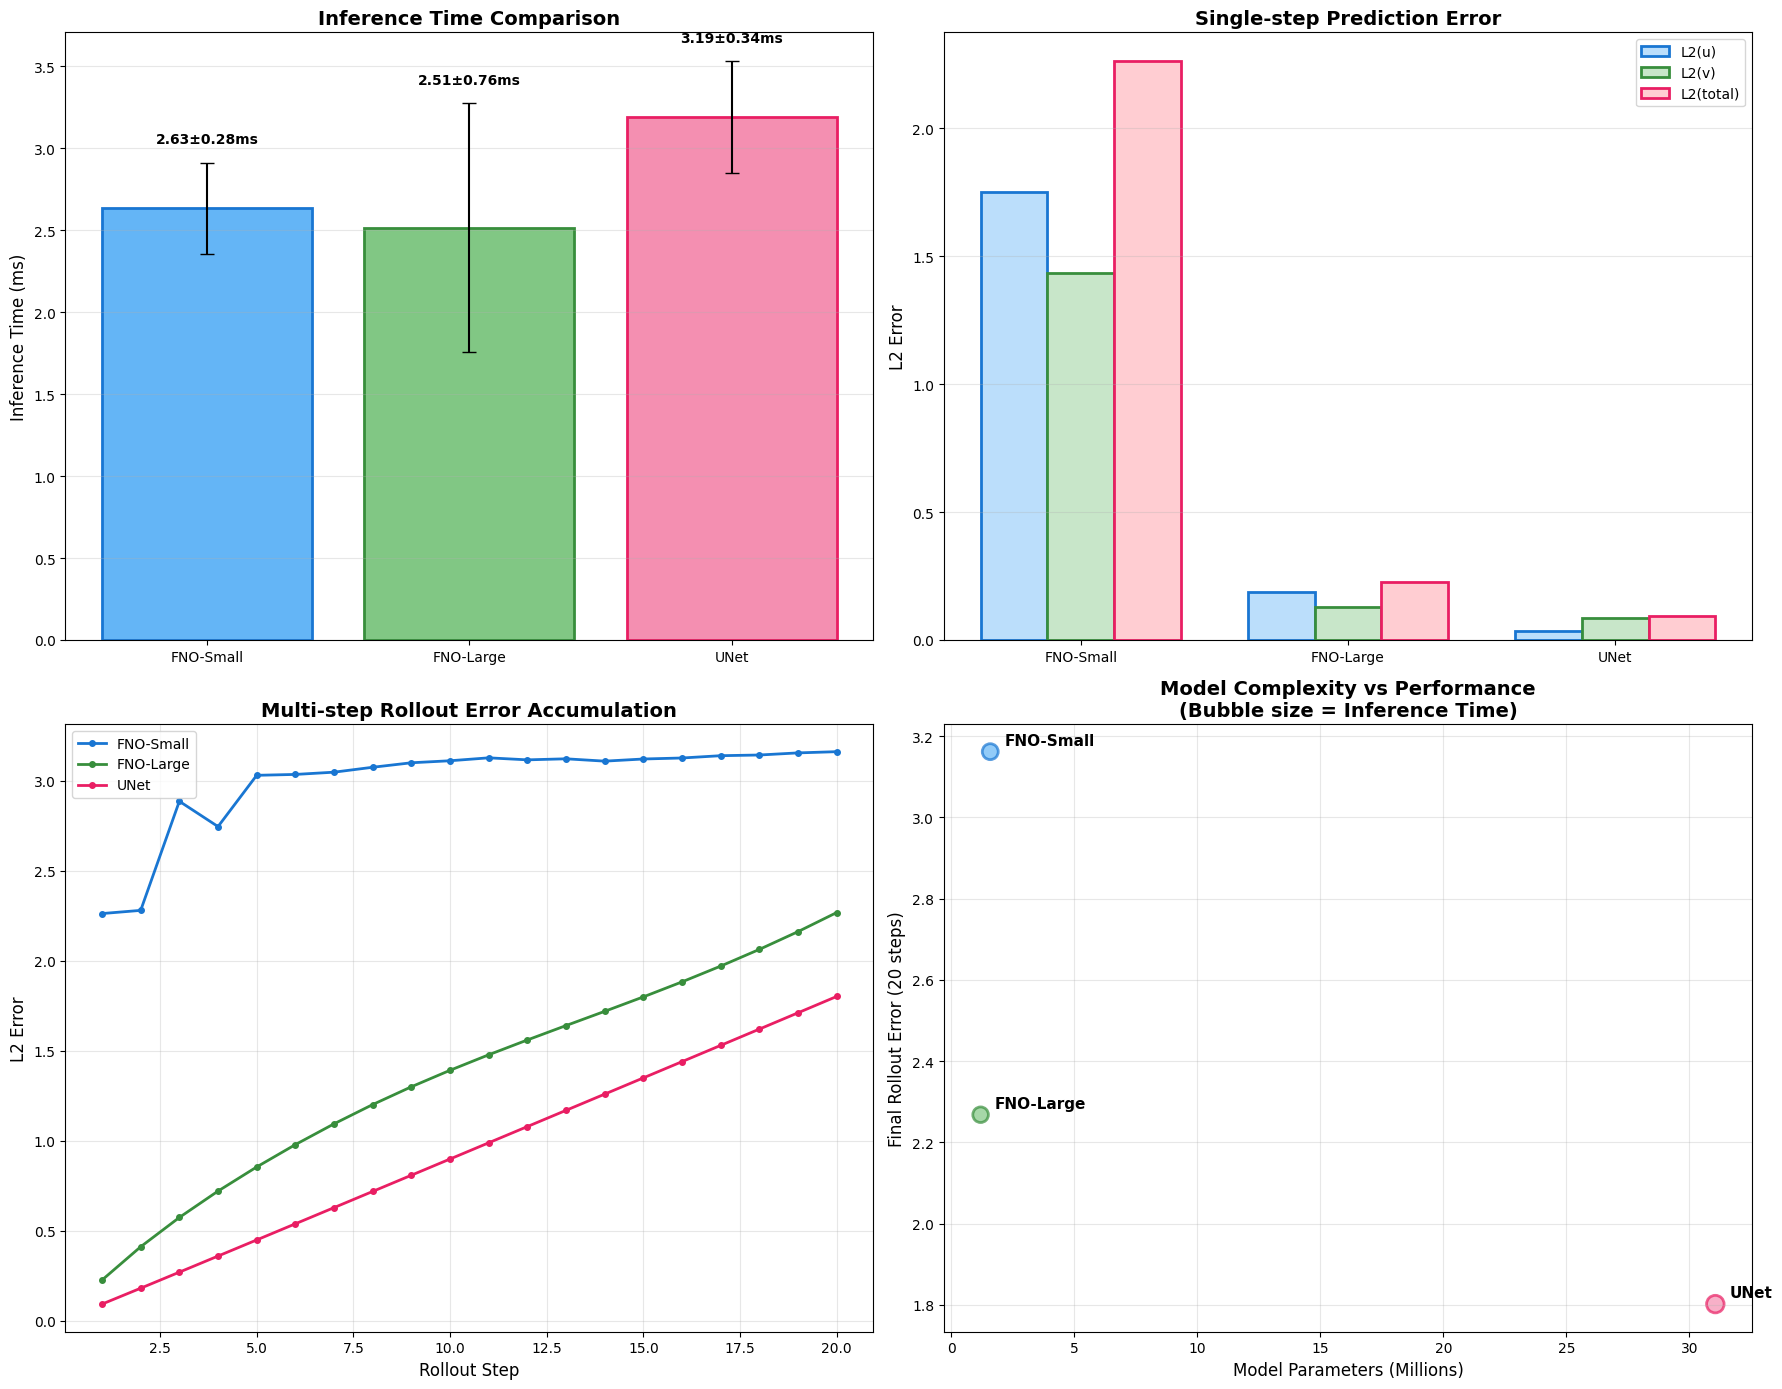


📊 COMPREHENSIVE BENCHMARK RESULTS
Model           Params       Time (ms)       L2(single)      L2(rollout@20) 
------------------------------------------------------------------------------------------
FNO-Small          1.581M   2.63±0.28     2.262373     3.161876
FNO-Large          1.189M   2.51±0.76     0.225958     2.268088
UNet              31.059M   3.19±0.34     0.092389     1.801871

🏆 BEST PERFORMERS:
   ⏱️  Fastest Inference: FNO-Large (2.51ms)
   🎯 Best Single-step Accuracy: UNet (L2=0.092389)
   📈 Best Rollout Stability: UNet (L2@20=1.801871)


In [34]:
# ========================================
# Visualize Benchmark Results
# ========================================

def visualize_benchmark_results(results, models_dict):
    """
    Create comprehensive visualization of benchmark results.
    """
    model_names = list(results.keys())
    n_models = len(model_names)
    colors = ['#64B5F6', '#81C784', '#F48FB1']  # Blue, Green, Pink
    edge_colors = ['#1976D2', '#388E3C', '#E91E63']
    
    fig = plt.figure(figsize=(18, 14))
    
    # ========== Plot 1: Inference Time Bar Chart ==========
    ax1 = fig.add_subplot(2, 2, 1)
    means = [results[name]['time_mean'] for name in model_names]
    stds = [results[name]['time_std'] for name in model_names]
    
    bars = ax1.bar(model_names, means, yerr=stds, capsize=5, 
                   color=colors[:n_models], edgecolor=edge_colors[:n_models], linewidth=2)
    ax1.set_ylabel('Inference Time (ms)', fontsize=12)
    ax1.set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, mean, std in zip(bars, means, stds):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.1,
                 f'{mean:.2f}±{std:.2f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # ========== Plot 2: Single-step L2 Error Bar Chart ==========
    ax2 = fig.add_subplot(2, 2, 2)
    l2_totals = [results[name]['l2_total'] for name in model_names]
    l2_u = [results[name]['l2_u'] for name in model_names]
    l2_v = [results[name]['l2_v'] for name in model_names]
    
    x = np.arange(n_models)
    width = 0.25
    
    bars1 = ax2.bar(x - width, l2_u, width, label='L2(u)', color='#BBDEFB', edgecolor='#1976D2', linewidth=2)
    bars2 = ax2.bar(x, l2_v, width, label='L2(v)', color='#C8E6C9', edgecolor='#388E3C', linewidth=2)
    bars3 = ax2.bar(x + width, l2_totals, width, label='L2(total)', color='#FFCDD2', edgecolor='#E91E63', linewidth=2)
    
    ax2.set_ylabel('L2 Error', fontsize=12)
    ax2.set_title('Single-step Prediction Error', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # ========== Plot 3: Rollout Error Over Time ==========
    ax3 = fig.add_subplot(2, 2, 3)
    for i, name in enumerate(model_names):
        rollout_errors = results[name]['rollout_errors']
        ax3.plot(range(1, len(rollout_errors) + 1), rollout_errors, 
                 marker='o', markersize=4, linewidth=2, 
                 color=edge_colors[i], label=name)
    
    ax3.set_xlabel('Rollout Step', fontsize=12)
    ax3.set_ylabel('L2 Error', fontsize=12)
    ax3.set_title('Multi-step Rollout Error Accumulation', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # ========== Plot 4: Model Complexity vs Performance ==========
    ax4 = fig.add_subplot(2, 2, 4)
    
    param_counts = [count_parameters(models_dict[name]) / 1e6 for name in model_names]  # In millions
    rollout_final = [results[name]['rollout_final'] for name in model_names]
    inference_times = [results[name]['time_mean'] for name in model_names]
    
    # Bubble chart: x=params, y=rollout error, size=inference time
    scatter = ax4.scatter(param_counts, rollout_final, 
                          s=[t * 50 for t in inference_times],  # Scale for visibility
                          c=colors[:n_models], edgecolors=edge_colors[:n_models], 
                          linewidth=2, alpha=0.7)
    
    for i, name in enumerate(model_names):
        ax4.annotate(name, (param_counts[i], rollout_final[i]), 
                     textcoords="offset points", xytext=(10, 5), 
                     fontsize=11, fontweight='bold')
    
    ax4.set_xlabel('Model Parameters (Millions)', fontsize=12)
    ax4.set_ylabel('Final Rollout Error (20 steps)', fontsize=12)
    ax4.set_title('Model Complexity vs Performance\n(Bubble size = Inference Time)', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comprehensive_benchmark.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # ========== Print Summary Table ==========
    print("\n" + "=" * 90)
    print("📊 COMPREHENSIVE BENCHMARK RESULTS")
    print("=" * 90)
    print(f"{'Model':<15} {'Params':<12} {'Time (ms)':<15} {'L2(single)':<15} {'L2(rollout@20)':<15}")
    print("-" * 90)
    for name in model_names:
        params = count_parameters(models_dict[name])
        time_mean = results[name]['time_mean']
        time_std = results[name]['time_std']
        l2_single = results[name]['l2_total']
        l2_rollout = results[name]['rollout_final']
        print(f"{name:<15} {params/1e6:>8.3f}M {time_mean:>6.2f}±{time_std:>4.2f} {l2_single:>12.6f} {l2_rollout:>12.6f}")
    print("=" * 90)
    
    # Best model summary
    best_time = min(model_names, key=lambda x: results[x]['time_mean'])
    best_single = min(model_names, key=lambda x: results[x]['l2_total'])
    best_rollout = min(model_names, key=lambda x: results[x]['rollout_final'])
    
    print("\n🏆 BEST PERFORMERS:")
    print(f"   ⏱️  Fastest Inference: {best_time} ({results[best_time]['time_mean']:.2f}ms)")
    print(f"   🎯 Best Single-step Accuracy: {best_single} (L2={results[best_single]['l2_total']:.6f})")
    print(f"   📈 Best Rollout Stability: {best_rollout} (L2@20={results[best_rollout]['rollout_final']:.6f})")

# Run visualization
if 'benchmark_results' in dir():
    visualize_benchmark_results(
        benchmark_results,
        {
            'FNO-Small': fno_small,
            'FNO-Large': fno_large,
            'UNet': unet_model
        }
    )
else:
    print("⚠️ Benchmark results not available. Please run the benchmark cell first.")

## Understanding FNO Spectral Truncation Analysis

This diagram reveals a fundamental limitation of Fourier Neural Operators (FNO): **spectral truncation**. Here's what each component shows:

### Left Plot: Power Spectrum Comparison
- **Blue line (Ground Truth)**: The true energy distribution of the velocity field across all spatial frequencies
- **Green dashed line (FNO Prediction)**: The energy distribution predicted by FNO with truncated modes
- **Red vertical line**: The truncation boundary at k=12 modes
- **Green shaded region**: The frequency band that FNO can capture (0 to 12 modes)

**Key Insight**: Notice how the FNO prediction (green) drops to near-zero beyond k=12. This is because FNO only learns from the low-frequency components—it literally **cannot represent high-frequency information** beyond its mode limit.

### Right Plot: Spectral Ratio (Prediction/Ground Truth)
- **Y-axis = 1.0 line (gray dashed)**: Represents perfect prediction (ratio = 1)
- **Purple line**: Shows how well FNO captures each frequency band relative to ground truth
- **Red shaded area**: Under-prediction regions (FNO captures less energy than GT)
- **Blue shaded area**: Over-prediction regions (FNO captures more energy than GT)

**Key Insight**: 
- **Below k=12**: The ratio is close to 1, meaning FNO captures low frequencies well
- **Above k=12**: The ratio drops significantly, showing FNO severely under-predicts high frequencies
- This explains why FNO produces smooth, over-blurred predictions—it's missing the fine-scale details

### Physical Interpretation
In fluid dynamics (CFD), high-frequency content represents:
- **Turbulent eddies** and small-scale vortices
- **Sharp gradients** at boundaries
- **Fine-grained flow structures**

By truncating these frequencies, FNO trades **accuracy for computational speed**, resulting in:
✓ Faster inference (fewer modes = less computation)
✗ Loss of small-scale features
✗ Over-smoothed velocity fields

### How to Read the Patterns
1. **Flat ratio above k=12** → Complete loss of information at those frequencies
2. **Steep drop around k=12** → Sharp transition between captured and lost information
3. **Ratio < 1 in high freqs** → FNO under-predicts the remaining energy it tries to capture

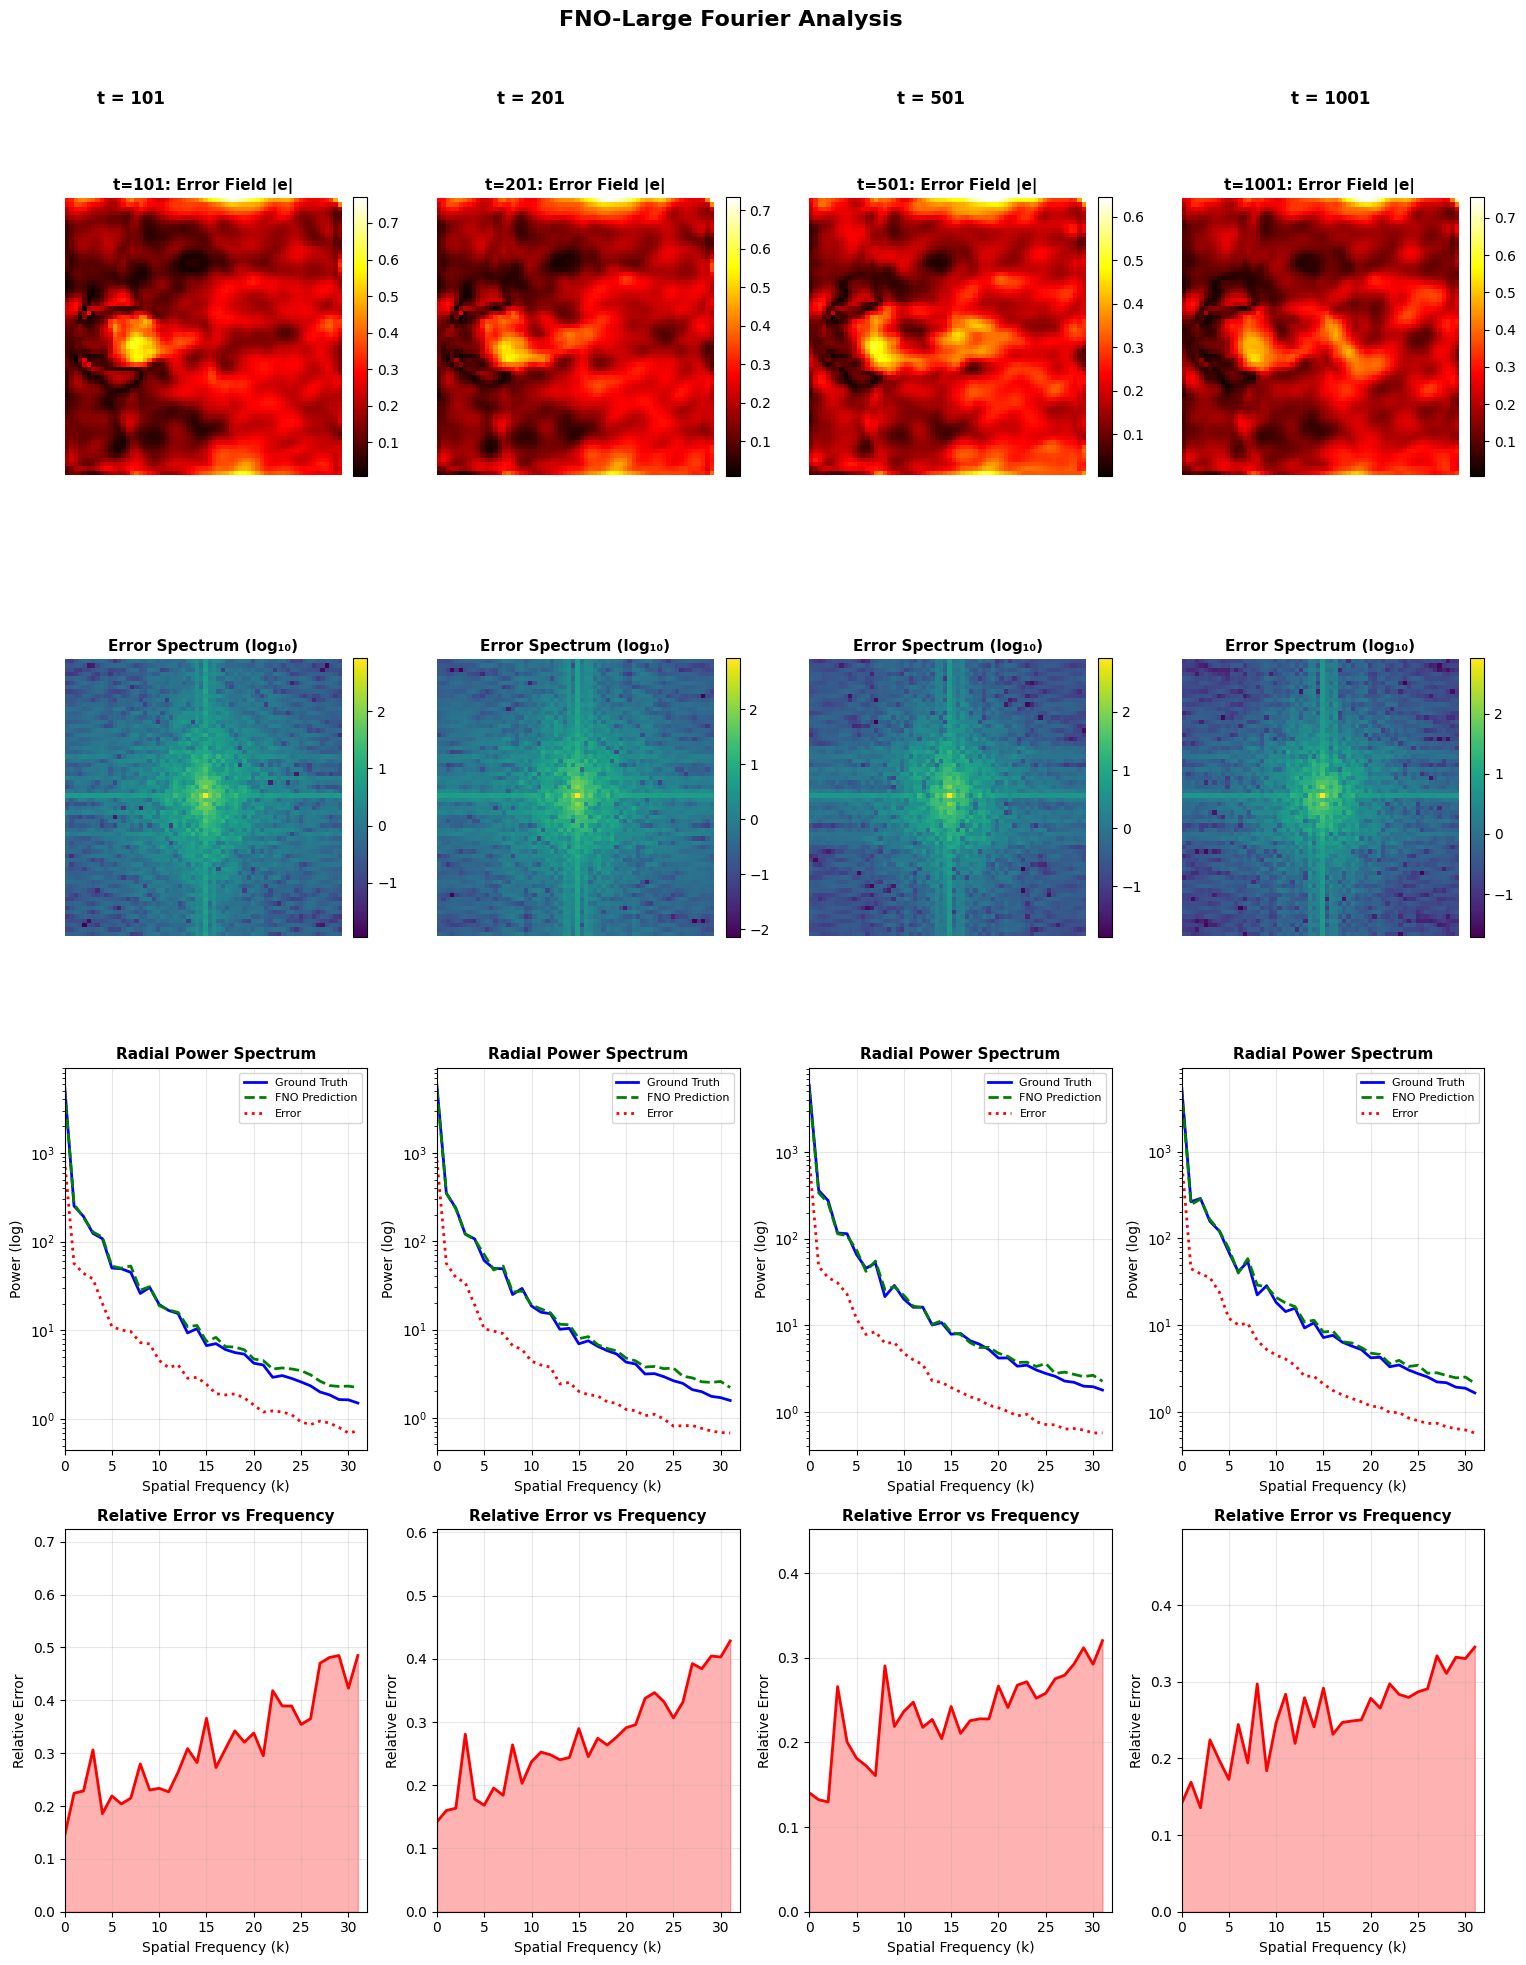


📊 FNO-Large 误差频谱分析总结

关键发现:
• 低频区 (k < 10): 大尺度流场结构误差
• 中频区 (10 < k < 20): 中等尺度涡旋误差
• 高频区 (k > 20): 小尺度湍流细节误差

注意:
• FNO 使用 modes=12，理论上只保留前12个傅里叶模式
• 高频误差可能反映了频谱截断的影响


In [49]:
# ========================================
# FNO-Large Error Fourier Analysis
# ========================================

def analyze_error_fourier(
    u_data, v_data, metadata,
    model,
    timesteps=[100, 200, 500, 1000],
    device=device
):
    """
    对 FNO-Large 预测误差进行傅里叶变换分析
    """
    from scipy import fft as scipy_fft
    
    fig = plt.figure(figsize=(16, 20))
    
    for idx, t in enumerate(timesteps):
        if t >= len(u_data) - 1:
            t = len(u_data) - 2
        
        # Ground truth
        u_t = u_data[t]
        v_t = v_data[t]
        u_gt = u_data[t + 1]
        v_gt = v_data[t + 1]
        
        # FNO prediction
        x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
        with torch.no_grad():
            pred = model(x_fno).cpu().numpy()[0]
        u_pred, v_pred = pred[..., 0], pred[..., 1]
        
        # Compute error fields
        error_u = u_pred - u_gt
        error_v = v_pred - v_gt
        error_mag = np.sqrt(error_u**2 + error_v**2)
        
        # 2D FFT of error
        error_fft = np.fft.fft2(error_mag)
        error_fft_shifted = np.fft.fftshift(error_fft)
        error_spectrum = np.abs(error_fft_shifted)
        
        # 2D FFT of ground truth velocity magnitude
        gt_mag = np.sqrt(u_gt**2 + v_gt**2)
        gt_fft = np.fft.fft2(gt_mag)
        gt_fft_shifted = np.fft.fftshift(gt_fft)
        gt_spectrum = np.abs(gt_fft_shifted)
        
        # 2D FFT of prediction velocity magnitude
        pred_mag = np.sqrt(u_pred**2 + v_pred**2)
        pred_fft = np.fft.fft2(pred_mag)
        pred_fft_shifted = np.fft.fftshift(pred_fft)
        pred_spectrum = np.abs(pred_fft_shifted)
        
        # Row for this timestep - now using 4 rows and len(timesteps) columns
        row = idx
        
        # Plot 1: Spatial error field
        ax1 = fig.add_subplot(4, len(timesteps), row + 1)
        im1 = ax1.imshow(error_mag, cmap='hot', origin='lower')
        ax1.set_title(f't={t+1}: Error Field |e|', fontsize=11, fontweight='bold')
        ax1.axis('off')
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        
        # Plot 2: Error spectrum (log scale)
        ax2 = fig.add_subplot(4, len(timesteps), len(timesteps) + row + 1)
        im2 = ax2.imshow(np.log10(error_spectrum + 1e-10), cmap='viridis', origin='lower')
        ax2.set_title(f'Error Spectrum (log₁₀)', fontsize=11, fontweight='bold')
        ax2.axis('off')
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        # Plot 3: GT vs Pred spectrum comparison (1D radial average)
        ax3 = fig.add_subplot(4, len(timesteps), 2 * len(timesteps) + row + 1)
        
        # Compute radial average
        h, w = gt_spectrum.shape
        cy, cx = h // 2, w // 2
        y, x = np.ogrid[:h, :w]
        r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
        max_r = min(cx, cy)
        
        # Radial average for each spectrum
        gt_radial = np.zeros(max_r)
        pred_radial = np.zeros(max_r)
        error_radial = np.zeros(max_r)
        counts = np.zeros(max_r)
        
        for i in range(h):
            for j in range(w):
                ri = r[i, j]
                if ri < max_r:
                    gt_radial[ri] += gt_spectrum[i, j]
                    pred_radial[ri] += pred_spectrum[i, j]
                    error_radial[ri] += error_spectrum[i, j]
                    counts[ri] += 1
        
        gt_radial /= (counts + 1e-10)
        pred_radial /= (counts + 1e-10)
        error_radial /= (counts + 1e-10)
        
        freqs = np.arange(max_r)
        ax3.semilogy(freqs, gt_radial, 'b-', linewidth=2, label='Ground Truth')
        ax3.semilogy(freqs, pred_radial, 'g--', linewidth=2, label='FNO Prediction')
        ax3.semilogy(freqs, error_radial, 'r:', linewidth=2, label='Error')
        ax3.set_xlabel('Spatial Frequency (k)', fontsize=10)
        ax3.set_ylabel('Power (log)', fontsize=10)
        ax3.set_title('Radial Power Spectrum', fontsize=11, fontweight='bold')
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)
        ax3.set_xlim(0, max_r)
        
        # Plot 4: Relative error spectrum (error/gt)
        ax4 = fig.add_subplot(4, len(timesteps), 3 * len(timesteps) + row + 1)
        relative_error = error_radial / (gt_radial + 1e-10)
        ax4.plot(freqs, relative_error, 'r-', linewidth=2)
        ax4.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax4.fill_between(freqs, 0, relative_error, alpha=0.3, color='red')
        ax4.set_xlabel('Spatial Frequency (k)', fontsize=10)
        ax4.set_ylabel('Relative Error', fontsize=10)
        ax4.set_title('Relative Error vs Frequency', fontsize=11, fontweight='bold')
        ax4.grid(alpha=0.3)
        ax4.set_xlim(0, max_r)
        ax4.set_ylim(0, min(5, np.percentile(relative_error, 95) * 1.5))
    
    # Add column labels on the top (below title to avoid overlap)
    for idx, t in enumerate(timesteps):
        if t >= len(u_data) - 1:
            t = len(u_data) - 2
        # Calculate position for column labels, spaced below the title
        x_pos = (idx + 0.5) / len(timesteps)
        fig.text(x_pos, 0.94, f't = {t+1}', va='top', ha='center',
                 fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0.04, 0, 1, 0.92])
    fig.suptitle('FNO-Large Fourier Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig('fno_error_fourier_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # ========== Summary Statistics ==========
    print("\n" + "=" * 70)
    print("📊 FNO-Large 误差频谱分析总结")
    print("=" * 70)
    print("\n关键发现:")
    print("• 低频区 (k < 10): 大尺度流场结构误差")
    print("• 中频区 (10 < k < 20): 中等尺度涡旋误差")
    print("• 高频区 (k > 20): 小尺度湍流细节误差")
    print("\n注意:")
    print("• FNO 使用 modes=12，理论上只保留前12个傅里叶模式")
    print("• 高频误差可能反映了频谱截断的影响")

# Run Fourier analysis
if 'u_data' in dir() and 'v_data' in dir() and 'fno_large' in dir():
    analyze_error_fourier(
        u_data, v_data, meta,
        fno_large,
        timesteps=[100, 200, 500, 1000],
        device=device
    )
else:
    print("⚠️ Data or model not loaded. Please run previous cells first.")

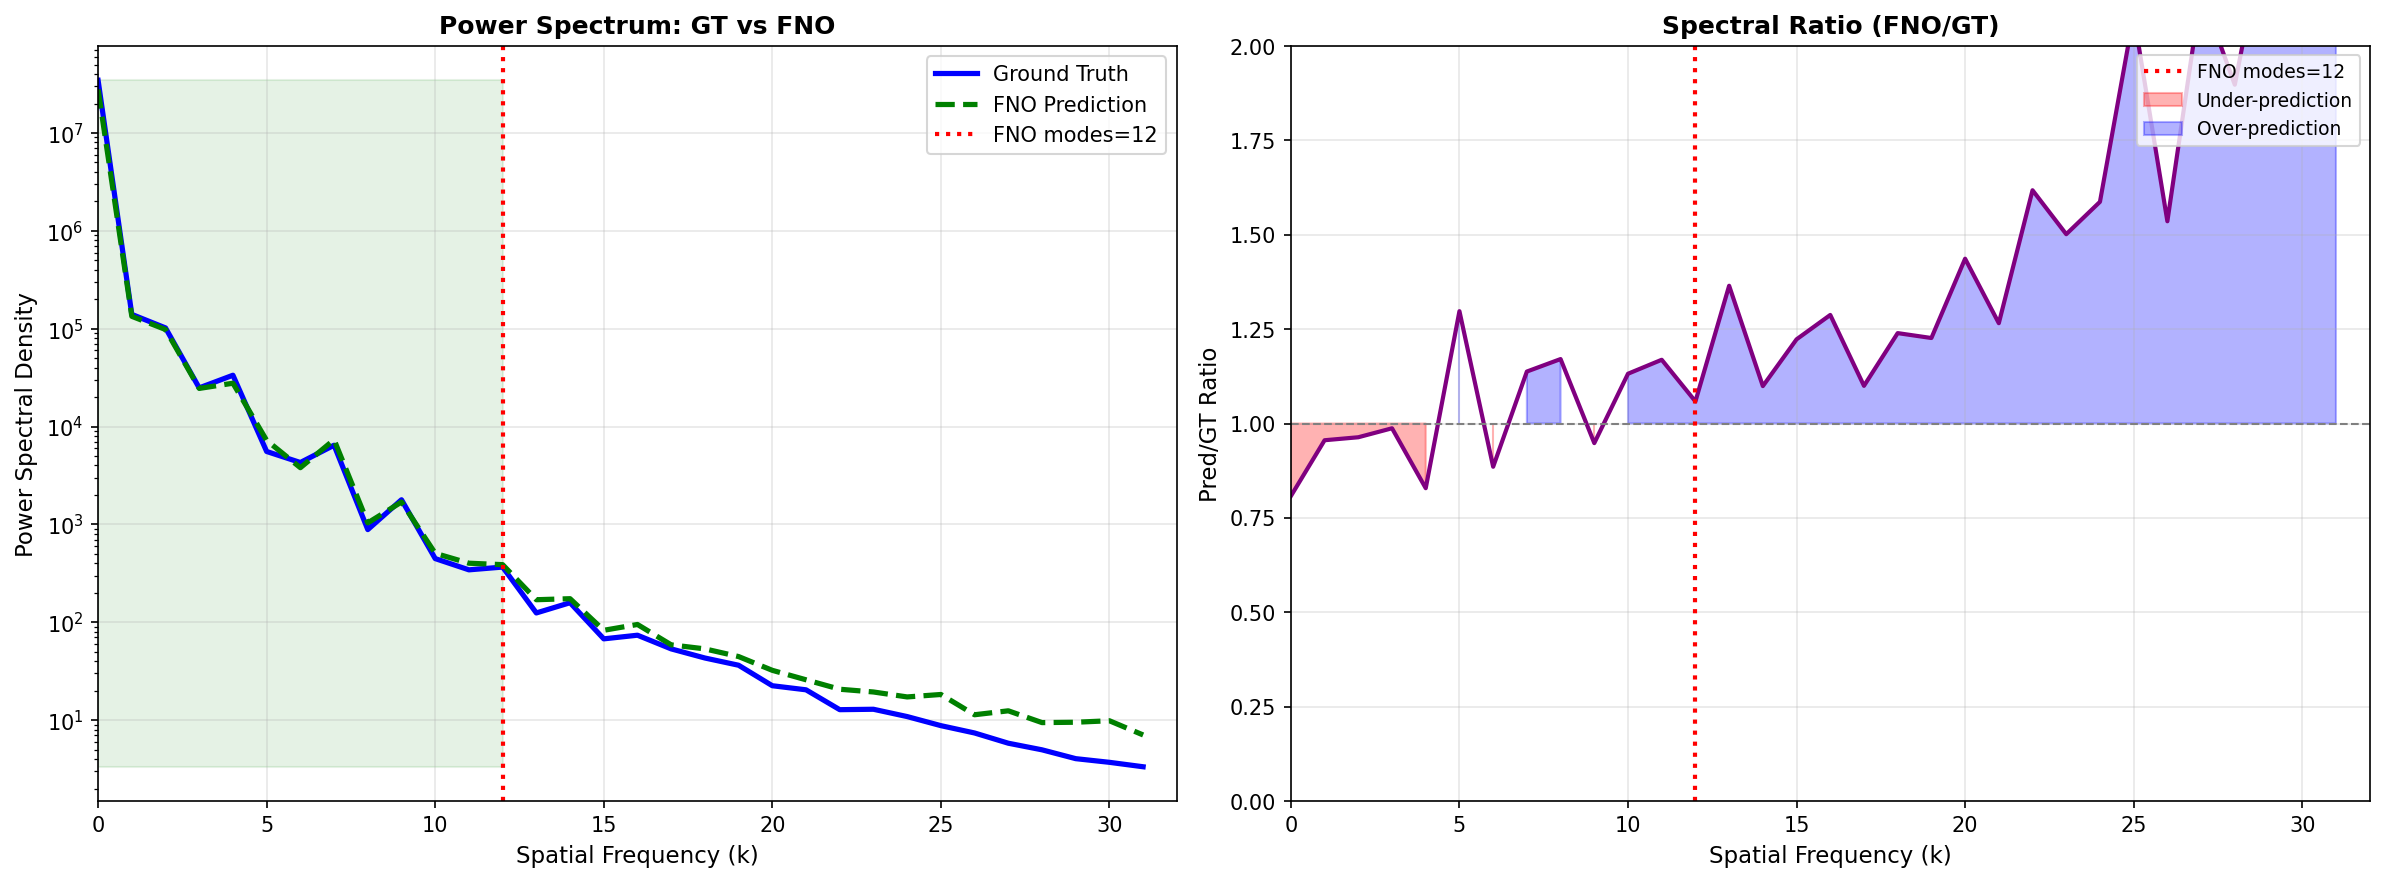


📊 FNO-Large Spectral Truncation Analysis (t=201, modes=12)

Freq Band                 GT Energy%      FNO Energy%     Diff           
----------------------------------------------------------------------
Low freq (k<modes)            100.00%     100.00%      -0.00%
Mid freq (modes<k<2×modes)       0.00%       0.00% +      0.00%
High freq (k>2×modes)           0.00%       0.00% +      0.00%

🔍 Key Findings:


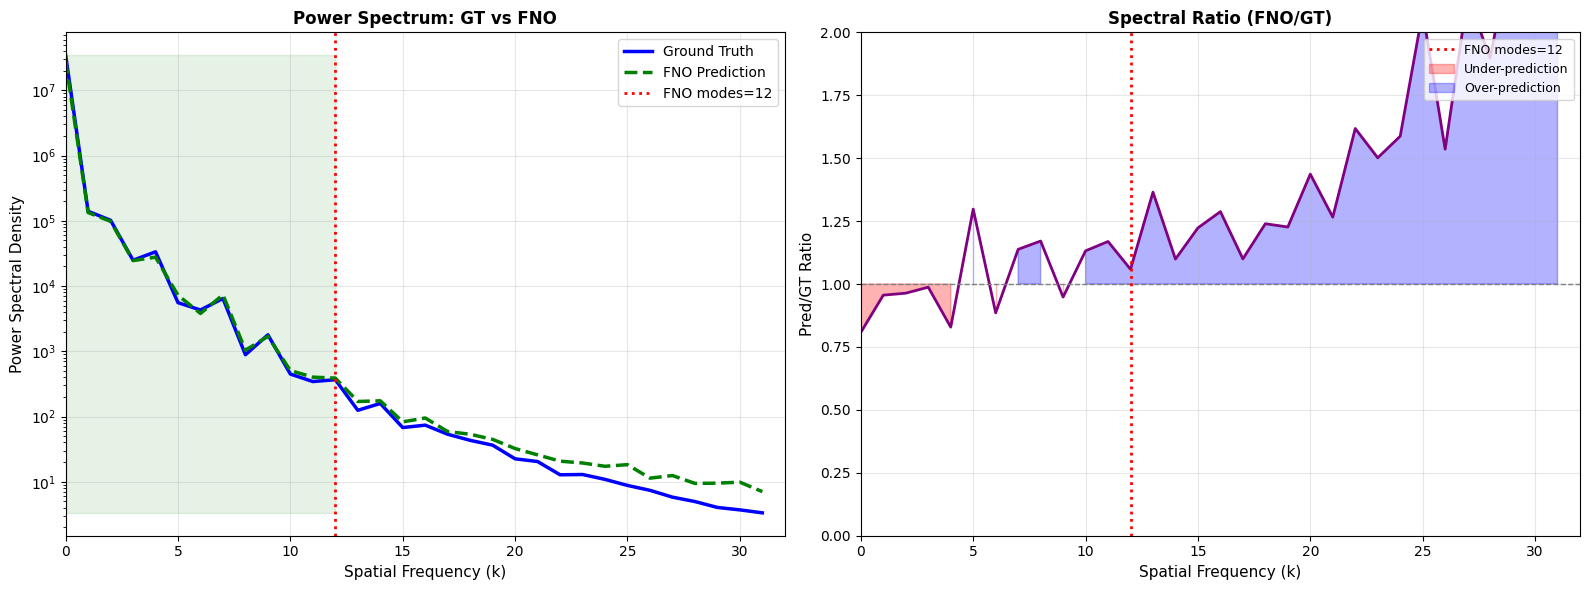

In [43]:
# ========================================
# Spectral Energy Distribution Comparison (FNO mode truncation effect)
# ========================================

def analyze_spectral_truncation(
    u_data, v_data, metadata,
    model,
    t=200,
    fno_modes=12,
    device=device
):
    """
    Analyze FNO spectral truncation effect - compare GT and prediction energy distribution across frequency bands
    """
    if t >= len(u_data) - 1:
        t = len(u_data) - 2
    
    # Ground truth
    u_t = u_data[t]
    v_t = v_data[t]
    u_gt = u_data[t + 1]
    v_gt = v_data[t + 1]
    
    # FNO prediction
    x_fno = prepare_input_fno(u_t, v_t, metadata).to(device)
    with torch.no_grad():
        pred = model(x_fno).cpu().numpy()[0]
    u_pred, v_pred = pred[..., 0], pred[..., 1]
    
    # Compute velocity magnitudes
    gt_mag = np.sqrt(u_gt**2 + v_gt**2)
    pred_mag = np.sqrt(u_pred**2 + v_pred**2)
    error_mag = np.sqrt((u_pred - u_gt)**2 + (v_pred - v_gt)**2)
    
    # 2D FFT
    gt_fft = np.fft.fft2(gt_mag)
    pred_fft = np.fft.fft2(pred_mag)
    error_fft = np.fft.fft2(error_mag)
    
    # Shift to center
    gt_fft_s = np.fft.fftshift(gt_fft)
    pred_fft_s = np.fft.fftshift(pred_fft)
    error_fft_s = np.fft.fftshift(error_fft)
    
    # Compute power spectra
    gt_power = np.abs(gt_fft_s)**2
    pred_power = np.abs(pred_fft_s)**2
    error_power = np.abs(error_fft_s)**2
    
    # Radial averaging
    h, w = gt_power.shape
    cy, cx = h // 2, w // 2
    max_r = min(cx, cy)
    
    gt_radial = np.zeros(max_r)
    pred_radial = np.zeros(max_r)
    error_radial = np.zeros(max_r)
    counts = np.zeros(max_r)
    
    for i in range(h):
        for j in range(w):
            r = int(np.sqrt((i - cy)**2 + (j - cx)**2))
            if r < max_r:
                gt_radial[r] += gt_power[i, j]
                pred_radial[r] += pred_power[i, j]
                error_radial[r] += error_power[i, j]
                counts[r] += 1
    
    gt_radial /= (counts + 1e-10)
    pred_radial /= (counts + 1e-10)
    error_radial /= (counts + 1e-10)
    
    # Create visualization - only show last two plots (frequency domain analysis)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========== Frequency domain analysis ==========
    freqs = np.arange(max_r)
    
    # Power spectrum comparison
    axes[0].semilogy(freqs, gt_radial, 'b-', linewidth=2.5, label='Ground Truth')
    axes[0].semilogy(freqs, pred_radial, 'g--', linewidth=2.5, label='FNO Prediction')
    axes[0].axvline(x=fno_modes, color='red', linestyle=':', linewidth=2, label=f'FNO modes={fno_modes}')
    axes[0].fill_betweenx([gt_radial.min(), gt_radial.max()], 0, fno_modes, alpha=0.1, color='green')
    axes[0].set_xlabel('Spatial Frequency (k)', fontsize=11)
    axes[0].set_ylabel('Power Spectral Density', fontsize=11)
    axes[0].set_title('Power Spectrum: GT vs FNO', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim(0, max_r)
    
    # Spectral ratio (pred/gt)
    spectral_ratio = pred_radial / (gt_radial + 1e-10)
    axes[1].plot(freqs, spectral_ratio, 'purple', linewidth=2)
    axes[1].axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
    axes[1].axvline(x=fno_modes, color='red', linestyle=':', linewidth=2, label=f'FNO modes={fno_modes}')
    axes[1].fill_between(freqs, 1, spectral_ratio, where=(spectral_ratio < 1), alpha=0.3, color='red', label='Under-prediction')
    axes[1].fill_between(freqs, 1, spectral_ratio, where=(spectral_ratio > 1), alpha=0.3, color='blue', label='Over-prediction')
    axes[1].set_xlabel('Spatial Frequency (k)', fontsize=11)
    axes[1].set_ylabel('Pred/GT Ratio', fontsize=11)
    axes[1].set_title('Spectral Ratio (FNO/GT)', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9, loc='upper right')
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim(0, max_r)
    axes[1].set_ylim(0, 2)
    
    # Define frequency bands for text analysis
    bands = [
        (0, fno_modes, 'Low freq (k<modes)', '#4CAF50'),
        (fno_modes, 2*fno_modes, 'Mid freq (modes<k<2×modes)', '#FFC107'),
        (2*fno_modes, max_r, 'High freq (k>2×modes)', '#F44336')
    ]
    
    gt_band_energy = []
    pred_band_energy = []
    error_band_energy = []
    band_labels = []
    
    for low, high, label, color in bands:
        gt_e = np.sum(gt_radial[low:min(high, max_r)])
        pred_e = np.sum(pred_radial[low:min(high, max_r)])
        error_e = np.sum(error_radial[low:min(high, max_r)])
        gt_band_energy.append(gt_e)
        pred_band_energy.append(pred_e)
        error_band_energy.append(error_e)
        band_labels.append(label)
    
    # Normalize
    gt_total = sum(gt_band_energy)
    pred_total = sum(pred_band_energy)
    error_total = sum(error_band_energy)
    
    gt_pct = [e/gt_total*100 for e in gt_band_energy]
    pred_pct = [e/pred_total*100 for e in pred_band_energy]
    error_pct = [e/error_total*100 for e in error_band_energy]
    
    plt.tight_layout()
    plt.savefig('fno_spectral_truncation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
    
    # Center the image in the output
    from IPython.display import Image, display
    display(Image('fno_spectral_truncation_analysis.png'))
    
    # Print analysis
    print("\n" + "=" * 70)
    print(f"📊 FNO-Large Spectral Truncation Analysis (t={t+1}, modes={fno_modes})")
    print("=" * 70)
    print(f"\n{'Freq Band':<25} {'GT Energy%':<15} {'FNO Energy%':<15} {'Diff':<15}")
    print("-" * 70)
    for i, label in enumerate(band_labels):
        diff = pred_pct[i] - gt_pct[i]
        sign = '+' if diff > 0 else ''
        print(f"{label.replace(chr(10), ' '):<25} {gt_pct[i]:>10.2f}% {pred_pct[i]:>10.2f}% {sign}{diff:>10.2f}%")
    print("=" * 70)
    
    print("\n🔍 Key Findings:")
    if pred_pct[2] < gt_pct[2] * 0.8:
        print(f"   ⚠️ Significant high-freq energy attenuation ({gt_pct[2]:.1f}% → {pred_pct[2]:.1f}%)")
        print(f"      → FNO spectral truncation causes high-freq detail loss")
    if error_pct[2] > 50:
        print(f"   ⚠️ Error concentrated in high-freq region ({error_pct[2]:.1f}%)")
        print(f"      → Consider increasing modes parameter to capture more high-freq info")
    if pred_pct[0] > gt_pct[0] * 1.1:
        print(f"   ⚠️ Over-concentration of low-freq energy ({gt_pct[0]:.1f}% → {pred_pct[0]:.1f}%)")
        print(f"      → May result in over-smoothed predictions")

# Run spectral truncation analysis
if 'u_data' in dir() and 'v_data' in dir() and 'fno_large' in dir():
    analyze_spectral_truncation(
        u_data, v_data, meta,
        fno_large,
        t=200,
        fno_modes=12,
        device=device
    )
else:
    print("⚠️ Data or model not loaded. Please run previous cells first.")